In [1]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

%matplotlib inline

# Question 1: Gradient and Newton methods

Given is the unconstrained optimization problem:

$
\textbf{minimize} \,\,\, f(x)=−\sum^m_{i=1} \log \left( 1−a^T_i x \right) − \sum^n_{i=1} \log \left(1−x^2_i \right)
$

with:

$
\begin{align}
& x \in \mathcal{R} \\
& \mathbf{dom}\,  f = \left \{ x \vert a^T_i x > 1, i = 1, \dots, m, \lvert x_i \rvert < 1, i= 1, \dots, n   \right \}
\end{align}
$

This is the problem of finding the analytical center for a set of inequalities:

$
a^T_i x <= 0\,\, , i=1, \dots, m \\
\lvert x \rvert <= 1 \,\, , i=1, \dots, n \\
$

### (a) Use the gradient method to solve the problem.

Compute expression for the **step direction**:

$
\begin{align}
\Delta x  &=& - \nabla f(x) \\
&=& \sum^m_{i=1} \frac{a_i^T}{1 - a^T_i x} + \sum^n_{i=1} \frac{2 x_i}{1 - x^2_i}
\end{align}
$

For **line search**, use backtracking with parameters $\alpha \in(0, 0.5)$ and $\beta \in (0, 1)$:

$
\begin{align}
t := 1 \\
\textrm{while}& \\
& f \left( x + t \Delta x \right) > f(x) + \alpha t \nabla f(x)^T \Delta x \\
& t:= \beta t
\end{align}
$



**Update:**

$
x := x + t \Delta x
$

**Stopping criterion:**

$
\Vert \nabla f(x) \Vert_2 \leq \eta
$

In [2]:
# Define problem
m = 200
n = 100
np.random.seed(1)
A = np.random.normal(size=(m, n))

In [3]:
# Define start value for x that is in the domain of f
x_0 = np.zeros(n)

In [4]:
# Define constants
ALPHA = 0.01
BETA = 0.5
ETA = 1e-3
MAX_ITERATIONS = 100

In [5]:
def evaluate_objective(x: np.ndarray, A: np.ndarray) -> float:
    return - np.sum(np.log(1 - A @ x)) - np.sum(np.log(1 - (x**2)))

In [6]:
def evaluate_gradient(x: np.ndarray, A: np.ndarray) -> np.ndarray:
    return A.T @ (1 / (1 - A @ x)) + 2 * x / (1 - x**2)

In [7]:
def backtracking_linesearch(
    x: np.ndarray,
    A: np.ndarray,
    Delta_x: np.ndarray,
    alpha: float,
    beta: float,
    verbose: bool = True
) -> float:
    # initialize t
    t = 1
    # First ensure that x + t * Delta_x is in the domain of f
    while ( 
        ((A @ (x + t * Delta_x)).max() >= 1) or (np.abs(x + t * Delta_x).max() > 1)
    ):
        if verbose:
            print(f"Updated x not in domain: reducing t ({t})")
        t *= beta
    while evaluate_objective(x + t * Delta_x, A) > (
        evaluate_objective(x, A) + alpha * t * evaluate_gradient(x, A).T @ Delta_x
    ):
        if verbose:
            print(f"Line search not yet converged: reducing t ({t})")
        t *= beta
    if verbose:
        print(f"Found step size t {(t)}")
    return t

In [8]:
# Perform gradient descent method
def gradient_descent(
    A: np.ndarray,
    x_start: np.ndarray,
    alpha: float,
    beta: float,
    max_iterations: int,
    eta: float
) -> Tuple[np.ndarray, np.ndarray]:

    x = x_start.copy()

    # Initialize lists for storing objective, step_size, and error
    objectives = [evaluate_objective(x, A)]
    step_sizes = []

    for i in range(max_iterations):
        Delta_x = - evaluate_gradient(x, A)
        if np.linalg.norm(Delta_x) < eta:
            break

        t = backtracking_linesearch(x, A, Delta_x, alpha, beta, verbose=False)

        x += t * Delta_x
        objectives.append(evaluate_objective(x, A))
        step_sizes.append(t)
    
    return objectives, step_sizes

In [9]:
# Compute optimal solution via cvxpy for comparison
def get_cvx_result(A: np.ndarray) -> float:
    x_var = cvx.Variable(A.shape[1])
    objective = cvx.Minimize(- cvx.sum(cvx.log(1 - A @ x_var)) - cvx.sum(cvx.log(1 - cvx.square(x_var))))
    problem = cvx.Problem(objective)
    return problem.solve()

In [10]:
objectives, step_sizes = gradient_descent(A, x_0, ALPHA, BETA, MAX_ITERATIONS, ETA)
errors = np.array(objectives) - get_cvx_result(A)

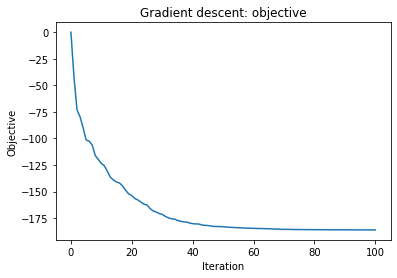

In [11]:
plt.plot(objectives)
plt.xlabel("Iteration");
plt.ylabel("Objective");
plt.title("Gradient descent: objective");

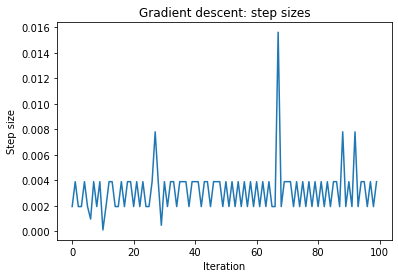

In [12]:
plt.plot(step_sizes)
plt.xlabel("Iteration");
plt.ylabel("Step size");
plt.title("Gradient descent: step sizes");

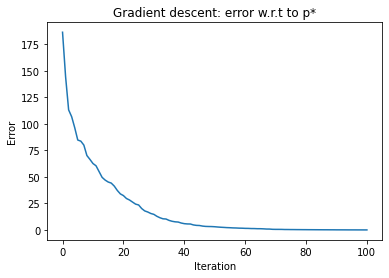

In [13]:
plt.plot(errors)
plt.xlabel("Iteration");
plt.ylabel("Error");
plt.title("Gradient descent: error w.r.t to p*");

### (a) Use the Newton method to solve the problem.

Note that a general purpose dense solver is acceptable for this problem.

1. Compute Newton step: 
$
\Delta x_{nt} := - \nabla^2 f(x)^{-1} \nabla f(x)
$

2. Compute Newton decrement: 
$
\lambda^2 := \nabla f(x)^T \nabla^2 f(x)^{-1} \nabla f(x) = -\nabla f(x) \Delta x_{nt}
$

3. Stopping criterion: 
$
\lambda^2 / 2 \leq \epsilon
$

4. Line search (here: use backtracking line search as for the gradient descent)

5. Update: 
$
x := x + t \Delta x_{nt}
$

Computing the hessian:

$$
\begin{align}
\nabla^2 f(x) &=& \nabla^2 \left( −\sum^m_{i=1} \log \left( 1−a^T_i x \right) − \sum^n_{i=1} \log \left(1−x^2_i \right)  \right) \\
&=&\nabla^2 \left( −\sum^m_{i=1} \log \left( 1−a^T_i x \right)  \right) - \nabla^2 \left( \sum^n_{i=1} \log \left(1−x^2_i \right) \right) \\
&=&\nabla^2 \left( −\sum^m_{i=1} \log \left( 1−a^T_i x \right)  \right) - \nabla^2 \left( \sum^n_{i=1} \log \left[ \left(1−x_i \right) \left( 1 + x_i\right) \right] \right) \\
&=&\nabla^2 \left( −\sum^m_{i=1} \log \left( 1−a^T_i x \right)  \right) - \nabla^2 \left( \sum^n_{i=1} 
\log \left(1−x_i \right) + \log \left( 1 + x_i\right) \right) \\
&=& \mathbf{A}^T \frac{1}{\mathbf{diag} \left(1-\mathbf{A} x \right)^2 } \mathbf{A}
    + \mathbf{diag}\frac{1}{\left( 1 - x \right)^2}
    + \mathbf{diag}\frac{1}{\left( 1 + x \right)^2} \\
&=& \mathbf{A}^T \frac{1}{\mathbf{diag} \left(1-\mathbf{A} x \right)^2 } \mathbf{A}
    + \mathbf{diag}\left( \frac{1}{\left( 1 - x \right)^2}
    + \frac{1}{\left( 1 + x \right)^2} \right)
\end{align}
$$

In [14]:
def evaluate_hessian(x: np.ndarray, A: np.ndarray) -> np.ndarray:
    return A.T @ np.diag(1.0 / (1.0 - A @ x)**2) @ A + np.diag( 1.0 / (1.0 - x)**2 + 1.0 / (1.0 + x)**2)

In [15]:
def evaluate_newton_decrement(gradient: np.ndarray, Delta_x):
    return - gradient.T @ Delta_x 

In [16]:
# Perform Newton descent method
def newton(
    A: np.ndarray,
    x_start: np.ndarray,
    alpha: float,
    beta: float,
    max_iterations: int,
    epsilon: float
) -> Tuple[np.ndarray, np.ndarray]:

    x = x_start.copy()

    # Initialize lists for storing objective, step_size, and error
    objectives = [evaluate_objective(x, A)]
    step_sizes = []

    for i in range(max_iterations):
        gradient = evaluate_gradient(x,A)
        Delta_x = np.linalg.lstsq(- evaluate_hessian(x, A), gradient)[0]  # select only the solution

        if evaluate_newton_decrement(gradient, Delta_x) < epsilon/2.0:
            print(f'Break at iteration {i} with lambda^2=={evaluate_newton_decrement(gradient, Delta_x)}')
            break

        t = backtracking_linesearch(x, A, Delta_x, alpha, beta, verbose=False)

        x += t * Delta_x
        objectives.append(evaluate_objective(x, A))
        step_sizes.append(t)
    
    return objectives, step_sizes

In [17]:
ALPHA = 0.01
BETA = 0.5
EPSILON = 1e-8
objectives, step_sizes = newton(A, x_0, ALPHA, BETA, MAX_ITERATIONS, EPSILON)
errors = np.array(objectives) - get_cvx_result(A)

C:\Users\Thomas\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Break at iteration 10 with lambda^2==2.2735813492287894e-15


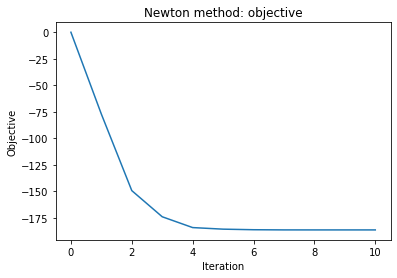

In [18]:
plt.plot(objectives)
plt.xlabel("Iteration");
plt.ylabel("Objective");
plt.title("Newton method: objective");

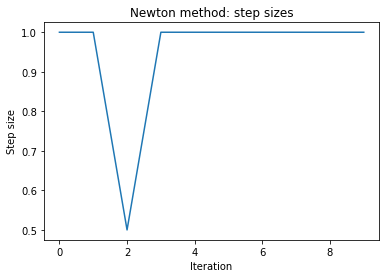

In [19]:
plt.plot(step_sizes)
plt.xlabel("Iteration");
plt.ylabel("Step size");
plt.title("Newton method: step sizes");

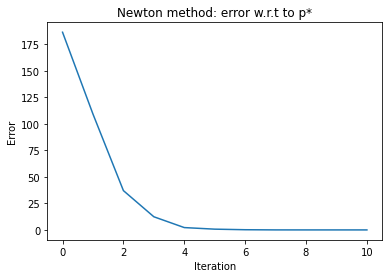

In [20]:
plt.plot(errors)
plt.xlabel("Iteration");
plt.ylabel("Error");
plt.title("Newton method: error w.r.t to p*");

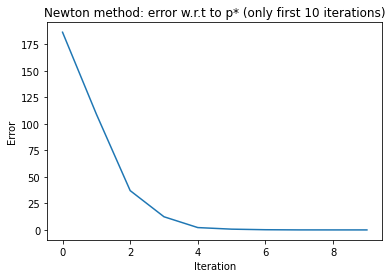

In [21]:
plt.plot(errors[:10])
plt.xlabel("Iteration");
plt.ylabel("Error");
plt.title("Newton method: error w.r.t to p* (only first 10 iterations)");

Convergence is much faster for the Newton method.

# Question 2: Efficient solution of basic portfolio optimization problem

Portfolio optimization problem:

$
\begin{align}
\mathbf{maximize} & \,\,\, \mu^T w - (\lambda/2) w^T \Sigma w \\
\mathbf{subject\,to} & \,\,\, \mathbf{1}^T w = 1
\end{align}
$

with:
* $w \in \mathcal{R}^n$ as the normalized portfolio, negative values indicate short positions
* $\mu$ as the mean return
* $\Sigma \in \mathcal{S}^n_{++}$ as the return covariance
* $\lambda > 0$ as the risk aversion parameter

$\Sigma$ has the form:

$
\Sigma = \mathbf{F Q F}^T + \mathbf{D}
$

with:
* $\mathbf{F} \in \mathcal{R}^{n \times k}$ with rank $k$ as the factor loading matrix
* $\mathbf{Q} \in \mathcal{S}^n_{++}$ as the factor covariance matrix
* $\mathbf{D}$ as the idiosyncratic risk, a diagonal matrix with positive entries 

### (a) What is the flop count for computing the optimal portfolio ignoring special structures of $\Sigma$.

Equality constraint convex quadratic optimization problems are treated in chapter 10.1.1. Solving this optimization problem is equivalent to solving the KKT equations.

In this case, the problem to be solved is:

$$
\begin{pmatrix}
\Sigma & \mathbf{1} \\
\mathbf{1}^T & 0 
\end{pmatrix}
\begin{pmatrix}
w \\
\nu
\end{pmatrix}
=
\begin{pmatrix}
\mu \\
1
\end{pmatrix}
$$

The total cost for solving this is (see C.6):
$$
f + n^2s + 2n_2^2 n_1 + (2/3) n^3_2
$$

Thereby $f$ is the cost of factorization and $s$ the cost of the associated solve step for the matrix $A_{11}$ which in this case is $\Sigma$. This cost analysis is dominated by the factorization costs $f$ for the $n \times n$ matrix $\Sigma$ which is $(1/3) n^3$ using the Cholesky facorization.

### (b) How can the optimal portfolio be computed more efficiently assuming $k << n$ and $\lambda = 1$.

In [22]:
# skipped

# Question 3: Sizing a gravity feed water supply network

In [73]:
# skipped

# Question 4: Flux balance analysis in systems biology 

In [23]:
# data file for flux balance analysis in systems biology
# From Segre, Zucker et al "From annotated genomes to metabolic flux
# models and kinetic parameter fitting" OMICS 7 (3), 301-316. 

In [24]:
# Stoichiometric matrix
S = np.array([
    # M1,M2,M3,M4,M5,M6
    [1., 0., 0., 0., 0., 0.],  #  R1:  extracellular -->  M1
    [-1., 1., 0., 0., 0., 0.],  #  R2:  M1 -->  M2
    [-1., 0., 1., 0., 0., 0.],  #  R3:  M1 -->  M3
    [0., -1., 0., 2., -1., 0.],  #  R4:  M2 + M5 --> 2 M4
    [0., 0., 0, 0, 1., 0.],  #  R5:  extracellular -->  M5
    [0., -2., 1., 0., 0., 1.],  #  R6:  2 M2 -->  M3 + M6
    [0., 0., -1., 1., 0., 0.],  #  R7:  M3 -->  M4
    [0., 0., 0., 0., 0., -1.],  #  R8:  M6 --> extracellular
    [0., 0., 0., -1., 0., 0.],  #  R9:  M4 --> cell biomass
]).T
m, n = S.shape

In [25]:
vmax = np.array(
    [
        10.10,  #  R1:  extracellular -->  M1
        100.,  #  R2:  M1 -->  M2
        5.90,  #  R3:  M1 -->  M3
        100.,  #  R4:  M2 + M5 --> 2 M4
        3.70,  #  R5:  extracellular -->  M5
        100.,  #  R6:  2 M2 --> M3 + M6
        100.,  #  R7:  M3 -->  M4
        100.,  #  R8:  M6 -->  extracellular
        100.,  #  R9:  M4 -->  cell biomass
    ]
)

### (a) What is the maximum possible cell growth rate G⋆?

In [26]:
v = cvx.Variable(n)

objective = cvx.Maximize(v[-1])

constraints = [
    S @ v.T == 0.0,
    v >= 0.0, 
    v <= vmax
]

problem = cvx.Problem(objective, constraints)
G_star = problem.solve()

In [27]:
print(f"The maximum possible growth rate G* is {G_star}.")

reactions = np.array(["R1", "R2", "R3", "R4", "R5", "R6", "R7", "R8", "R9"])
print(f'The following reactions are constrained by vmax (derived from Lagrange multiplier / dual values > 1e-10):\n'
      f'{reactions[constraints[2].dual_value > 1e-10]}')

print(f'The maximum growth rate is most sensitive to the reaction rate limit of reaction '
      f'{reactions[np.argmax(constraints[2].dual_value)]}.')

The maximum possible growth rate G* is 13.54999999695169.
The following reactions are constrained by vmax (derived from Lagrange multiplier / dual values > 1e-10):
['R1' 'R3' 'R5']
The maximum growth rate is most sensitive to the reaction rate limit of reaction R5.


In [28]:
constraints[2].dual_value

array([5.00000002e-01, 7.10287005e-12, 4.99999999e-01, 8.52981304e-12,
       1.50000000e+00, 7.32553008e-12, 7.16424880e-12, 6.89826960e-12,
       7.82565500e-12])

### (b) Essential genes and synthetic lethals

In [29]:
lethal = np.ndarray((n, n))
for i in range(n):
    for j in range(n):
        v = cvx.Variable(n)

        objective = cvx.Maximize(v[-1])

        constraints = [
            S @ v.T == 0.0,
            v >= 0.0, 
            v <= vmax,
            v[i] == 0,
            v[j] == 0
        ]

        problem = cvx.Problem(objective, constraints)
        G_star_ij = problem.solve()
        
        lethal[i,j] = G_star_ij < 0.2 * G_star

In [30]:
genes = np.array(["G1", "G2", "G3", "G4", "G5", "G6", "G7", "G8", "G9"])

In [31]:
essential_genes = genes[np.argwhere(np.diag(lethal) == 1)].flatten()
print(f"The essential genes are {essential_genes}")

The essential genes are ['G1' 'G9']


In [32]:
synthetic_lethals = sorted(
    set(  # drop duplicates
        [
            tuple(sorted(genes[combination]))
            for combination in np.argwhere(lethal == 1)
            if (
                not np.isin(combination[0], [0, 8])  # exclude essential genes
                and not np.isin(combination[1], [0, 8])  # exclude essential genes
            )
        ]
    )
)
print(
    f"The synthetic lethals (combinations of genes that are essential) are:\n{synthetic_lethals}"
)

The synthetic lethals (combinations of genes that are essential) are:
[('G2', 'G3'), ('G2', 'G7'), ('G4', 'G7'), ('G5', 'G7')]


# Question 5: Online advertising displays 

Problem description:

* $n$ - Total number of available ads
* $T$ - number of periods $t = 1, \dots, T$
* $N_{it} >= 0$ - number of impressions of add $i$ in time period $t$
* $I_t > 0$ - Number of impressions in a time period t
* $sum_{t=1}^T N_{it} = I_t$
* $R_{it} > 0$ - Revenue per impression for showing ad $i$ in time period $t$
* $\sum^T_{t=1} \sum^n_{i=1} R_{it} N_{it}$ - Total revenue
* $m$ - Number of contracts $j = 1, \dots, m$
* $\mathcal{A_j} \subseteq \{1, \dots, n\}$ - set of ads relevant for contract $j$
* $\mathcal{T_j} \subseteq \{1, \dots, T\}$ - set of time periods relevant for contract $j$
* $q_j \geq 0$ - target number of impressions for contract j
* $p_j > 0$ - shortfall penalty rate
* $s_j = \left( q_j - \sum_{t \in \mathcal{T}_j} \sum_{i \in \mathcal{A}_j} N_{it}    \right)_+$ - number of impressions by which we fall short of targe value $q_j$ for contract $j$
* $(\dots)_+ = \mathrm{max}(\dots, 0)$ - notation
* $\sum^m_{j=1} p_j s_j$ - Total penalty payment
* net profit - revenue minus total penalty

Goal, find $N_{it}$ that maximize net profit.

\begin{align}
\mathrm{maximize}& \,\, \sum^T_{t=1} \sum^n_{i=1} R_{it} N_{it} - \sum^m_{j=1} p_j \left( q_j - \sum_{t \in \mathcal{T}_j} \sum_{i \in \mathcal{A}_j} N_{it}    \right)_+ \\
\mathrm{subject\,to} & \,\, N_{it} >= 0 \\
& \,\, \sum_{t=1}^T N_{it} = I_t
\end{align}

This problem can be written as:

\begin{align}
\mathrm{maximize}& \,\, \sum^T_{t=1} \sum^n_{i=1} R_{it} N_{it} - \sum^m_{j=1} p_j \left( q_j - \mathrm{diag}\left({A^T N_{it} T }\right)  \right)_+ \\
\mathrm{subject\,to} & \,\, N_{it} >= 0 \\
& \,\, \sum_{i=1}^n N_{it} = I_t
\end{align}

where A and T are indicator matricies with dimensions $n \times m$ (ads $\times$ contracts) and $T \times m$ (time slots $\times$ contracts). $N_{it}$ (dimensions $n \times T$, i.e. ads $\times$ time slots) is the number of actual impressions per time slot. The diagonal of the vector multiplication is taken because contracts $j_k$ are independent from each other.  

The shortfalls $s_j$ are convex (note the $(\dots)_+$) so that the total objective is concave. The constraints are linear in $N_{it}$. So overall this is a convex optimization problem.

In [33]:
n=100      # number of ads
m=30       # number of contracts
T=60       # number of periods

In [34]:
# number of impressions in each period
I = np.array([9.50129285147176,
2.31138513574288,
6.06842583541787,
4.85982468709300,
8.91298966148902,
7.62096833027395,
4.56467665168341,
0.185036432482244,
8.21407164295253,
4.44703364353194,
6.15432348100095,
7.91937037427035,
9.21812970744803,
7.38207245810665,
1.76266144494618,
4.05706213062096,
9.35469699107605,
9.16904439913408,
4.10270206990945,
8.93649530913534,
0.578913047842686,
3.52868132217000,
8.13166497303758,
0.0986130066092356,
1.38890881956950,
2.02765218560273,
1.98721742661490,
6.03792479193819,
2.72187924969960,
1.98814267761062,
0.152739270290363,
7.46785676564429,
4.45096432287947,
9.31814578461665,
4.65994341675424,
4.18649467727506,
8.46221417824325,
5.25152496305172,
2.02647357650387,
6.72137468474289,
8.38118445052387,
0.196395138648175,
6.81277161282135,
3.79481018027998,
8.31796017609607,
5.02812883996251,
7.09471392703387,
4.28892365340997,
3.04617366869394,
1.89653747547175,
1.93431156405215,
6.82223223591384,
3.02764400776609,
5.41673853898088,
1.50872976149765,
6.97898481859863,
3.78373000512671,
8.60011604886820,
8.53655130662768,
5.93562912539682])

In [35]:
# revenue rate for each period and ad
R = np.array([[0.496552449703103, 0.608540361223992, 0.193893179984668, 0.812117818859680, 0.209271640662444, 0.754022665853817, 0.103449795964343, 0.171473221401946, 0.941348424003589, 0.970472374609106, 0.565730367752843, 0.0430624816095196, 0.410989656059366, 0.677253796879559, 0.232277247311882, 0.641032333444719, 0.304804564061337, 0.332767831293777, 0.469778599340395, 0.496630856907595, 0.00520117345017690, 0.211710375604536, 0.608753509052621, 0.551467564437952, 0.660082679511439, 0.489887222862427, 0.778441701413688, 0.665718684606177, 0.148613572797772, 0.720119250447617, 0.727612772283518, 0.789532959569616, 0.142298380515480, 0.164153157535986, 0.277290758286422, 0.203063091633605, 0.693592858723108, 0.974604478233260, 0.111600129154080, 0.843278295480441, 0.205736055776548, 0.908505447402678, 0.650856110495515, 0.519614357492339, 0.952516348051374, 0.199175330478481, 0.802289347573712, 0.0576283258496244, 0.666971555813294, 0.477387485870077, 0.991966375556591, 0.407041982914609, 0.405552584248945, 0.284686528078755, 0.312900534590898, 0.0406085623431721, 0.316859497093459, 0.807360106888272, 0.264735578966959, 0.294170394934126],
[0.899769175169610, 0.0157598179197507, 0.904812334166357, 0.610113576159260, 0.455091690772702, 0.663162007847106, 0.157336665897913, 0.130665751627127, 0.329864777956577, 0.486924995541901, 0.611898521652946, 0.370939343609933, 0.424787172125829, 0.586178316531219, 0.317878970969774, 0.995907789264187, 0.813839420438917, 0.292422838113973, 0.505804412295716, 0.00702417131883385, 0.759935507216594, 0.851088618549000, 0.209354383065127, 0.00651758862150758, 0.286058986547068, 0.155116599532513, 0.928032527448337, 0.597728207563107, 0.773292418843480, 0.938801749944267, 0.258532196034503, 0.899555397443098, 0.407842012540472, 0.777052276658668, 0.776444736587593, 0.417628506499082, 0.275064849148864, 0.402178276420749, 0.394284316427616, 0.242599812945803, 0.0947998303003754, 0.893093751837817, 0.861742015996731, 0.887104111057103, 0.927433659427095, 0.120944264437202, 0.381848204666765, 0.942494285865788, 0.631040400809322, 0.386686131569331, 0.633776777898382, 0.190482049963564, 0.898388948897691, 0.663174749912164, 0.173991147563118, 0.535218668833779, 0.0175524389935424, 0.422137684297341, 0.973945352871159, 0.629215167622703],
[0.821629160735343, 0.0163549335499965, 0.569205749671747, 0.701492600862577, 0.0810737252428633, 0.883493501892774, 0.407514980089251, 0.218781124017174, 0.704486301872423, 0.817468535546953, 0.102976522273357, 0.693302120772457, 0.954286374499041, 0.0649696187548357, 0.788791873204704, 0.499542418649513, 0.682093969709169, 0.402484670350054, 0.688386604578585, 0.316191532256937, 0.308679819860214, 0.742965160730047, 0.997734663947856, 0.125693298738784, 0.961383407593737, 0.651149413761709, 0.726217563829071, 0.404526607161529, 0.519910465659306, 0.00822373138200819, 0.469510639047991, 0.00217819552382965, 0.778151236667863, 0.560140929912689, 0.707981416220690, 0.203967539851539, 0.462150024035047, 0.515443897621539, 0.853273131215263, 0.369968066240963, 0.220744121577205, 0.614805966462668, 0.183019150388330, 0.242160193386215, 0.469291127364622, 0.401349703031613, 0.286858139047721, 0.527093962620277, 0.632120305606997, 0.243378088606180, 0.0168055612806841, 0.246113080921600, 0.302479562677303, 0.750196776105223, 0.101158120226332, 0.239135522376938, 0.968017094551155, 0.680151260958767, 0.720069993704977, 0.456253989327188],
[0.644910384193844, 0.190074589079726, 0.631789929221756, 0.0921962027196727, 0.851122400923855, 0.272157436384127, 0.407757021956663, 0.105480502669222, 0.943425460558310, 0.641571167846000, 0.158315917268311, 0.935824942847053, 0.881418613526660, 0.879211845786076, 0.634442764324637, 0.430051613332967, 0.882437242796043, 0.0341122996012775, 0.192865036670407, 0.738416629215361, 0.715255675042465, 0.405071000300670, 0.0167618206758681, 0.0557799314332881, 0.576555990636829, 0.726995014715514, 0.0953813782395832, 0.134026936766399, 0.586715591199659, 0.581682103312811, 0.857514499793157, 0.516336263673518, 0.162767372363302, 0.665111139321634, 0.602923250765925, 0.685578463128795, 0.643147608031115, 0.510142075473843, 0.739342405672492, 0.964646182600368, 0.160014444895156, 0.137717713995702, 0.0557505661424125, 0.0367070175185104, 0.315656245271395, 0.0672986699415242, 0.991337775773533, 0.884509124249877, 0.112025697951605, 0.599286214641884, 0.515549448717725, 0.931649559090165, 0.668352570745058, 0.108447370289027, 0.0290216740229897, 0.548416183503130, 0.843257465879799, 0.661898909892076, 0.332191295449686, 0.670550258747010],
[0.817974340839245, 0.586918471884673, 0.234412955408254, 0.424889141308687, 0.562048676523889, 0.419432715562144, 0.0526926876879721, 0.141425852251198, 0.581594337443889, 0.306349359513900, 0.413649859677563, 0.477575609168153, 0.698587666140596, 0.487909315968513, 0.659782849959993, 0.829168597878532, 0.0817989411070382, 0.287468887304399, 0.273565420363426, 0.790335931758027, 0.0809475181534987, 0.305041812587912, 0.439628160818214, 0.762673704854306, 0.966628827404731, 0.00367453399687062, 0.449299623627161, 0.301955478635484, 0.518979273544441, 0.556346827532562, 0.833412889419195, 0.624427106717429, 0.0262056976776571, 0.873564543695945, 0.0394189910398709, 0.831054595191860, 0.0374503122219488, 0.593532558378106, 0.762482388211248, 0.469057062694433, 0.640395234102043, 0.867452452308637, 0.323160200907918, 0.0185412245901873, 0.390720533122375, 0.979947730530123, 0.527785951709743, 0.733646372323412, 0.791348546207490, 0.840642309784145, 0.405218499700889, 0.106786292523428, 0.771078572756958, 0.343663068917791, 0.360546461135144, 0.523762453367160, 0.868417561868676, 0.937206419820798, 0.766172952800612, 0.104979463480365],
[0.660227556441602, 0.0575810898782886, 0.548782125538588, 0.375576658455746, 0.319296296395234, 0.212993658892489, 0.941815149857109, 0.456968301136205, 0.880154184846392, 0.660932132239465, 0.560410448537970, 0.129100097636583, 0.305401140585021, 0.891475566112523, 0.537583453411527, 0.116696061151110, 0.494825660300968, 0.219621338186992, 0.926326755492076, 0.400282654958422, 0.845877924079787, 0.474194974156385, 0.148395189668420, 0.0714015593047776, 0.513920944726360, 0.909142910329205, 0.976607746422573, 0.460327113233592, 0.140568161563973, 0.689377448464733, 0.475977042373957, 0.265189249218390, 0.851352729668915, 0.609828610850618, 0.845681609352609, 0.284374185437031, 0.894674902844961, 0.367741483902770, 0.235460565502989, 0.532929182290690, 0.640731058887739, 0.430263829780425, 0.180339991198761, 0.197654296017962, 0.134606617824885, 0.578632655755662, 0.352968069307125, 0.0866049399812864, 0.0918880899244567, 0.660501531547216, 0.248751761966527, 0.0100767700833205, 0.686447306380329, 0.878345924329668, 0.00736724328917838, 0.860510889938438, 0.150879838776351, 0.971822462200072, 0.499149688897861, 0.573702684979141],
[0.341970618270216, 0.367568038826344, 0.931583352579691, 0.166154080984799, 0.374899261447600, 0.0355999670519594, 0.149971684151172, 0.788133045457148, 0.749611644572081, 0.358017113387809, 0.268677291439962, 0.483831212074237, 0.829326093136976, 0.762294727652203, 0.919216602739482, 0.598684306417552, 0.430330776396020, 0.565927868027212, 0.234740862872384, 0.399887622905200, 0.718376203312797, 0.144737665764555, 0.621445936372610, 0.718233352788934, 0.864223317170780, 0.661860831358559, 0.968944141099814, 0.503275701408056, 0.315919441841284, 0.760952736505537, 0.340134549808239, 0.398981692754455, 0.252927048968912, 0.938838717566966, 0.229741291709345, 0.372043200857109, 0.965994446809075, 0.112263374291339, 0.757028050725188, 0.0540380118858489, 0.248972453232160, 0.788327489972765, 0.625473225460442, 0.210639454872239, 0.149562848168243, 0.0142774666427206, 0.451061657669974, 0.710670933709593, 0.337703127233462, 0.653757206380515, 0.355410182511077, 0.136403593839494, 0.739634012109937, 0.0635575035206532, 0.579196547738423, 0.0661289760164078, 0.0624065315456779, 0.637521305726793, 0.452519692801551, 0.00101039951521302],
[0.289725895856238, 0.631451164744443, 0.335197430206395, 0.833151459452637, 0.867795697911622, 0.0811637040907849, 0.384374046162991, 0.281063976092213, 0.379617342270692, 0.938199430101214, 0.784254164265667, 0.945597161714893, 0.970604574630724, 0.655304819563191, 0.780506043786454, 0.221224555534588, 0.345457576683296, 0.870092893576505, 0.127981872257783, 0.251691908070322, 0.870392998019119, 0.494340150098562, 0.754368784883181, 0.140407996962308, 0.225327507559789, 0.0496395179425465, 0.645270089875852, 0.762936194366473, 0.861279010543465, 0.824291948047736, 0.542214150356017, 0.977628314719835, 0.395155673140611, 0.285572282100381, 0.495063162540776, 0.556776515387895, 0.194584093989925, 0.608744551580542, 0.232155527980606, 0.622280299857701, 0.126538995291727, 0.944013004761612, 0.497550237792692, 0.924424381511400, 0.938330984233617, 0.684283803305275, 0.938430640024822, 0.518001411525807, 0.847759034199402, 0.746848014245378, 0.00824580117775067, 0.462191473151209, 0.192349208299136, 0.735852372306446, 0.923316083563699, 0.123845127934632, 0.753990280527579, 0.184994079533910, 0.630526988646904, 0.732879066782394],
[0.341193569414884, 0.717634421465697, 0.655531055012015, 0.838639704658968, 0.372176240119196, 0.850566783245386, 0.311058559097371, 0.224786730663751, 0.725561279297824, 0.487666974764866, 0.387870784730835, 0.367744133473682, 0.300102716834190, 0.971481519044378, 0.326709480246191, 0.398676875452060, 0.913659615602750, 0.254986482994225, 0.412617818588400, 0.0919118601297056, 0.872159692366126, 0.530124238103213, 0.280596952518100, 0.615698355475776, 0.243455031596262, 0.452224798819707, 0.0927470866346255, 0.944275815501710, 0.433448760914185, 0.527692784228855, 0.561502693916856, 0.303707418587631, 0.687287973327372, 0.764895642472623, 0.0300643780914117, 0.337917792196327, 0.153937317181675, 0.527434375899446, 0.460859099822412, 0.665177772536535, 0.814933159649039, 0.753179236143360, 0.717927848778869, 0.565238736820244, 0.640336768154392, 0.817422291843800, 0.190272181501986, 0.722978585891271, 0.949098268981596, 0.0947562980162714, 0.217357213781403, 0.0936638897838008, 0.688971047969596, 0.253613263561828, 0.201546468447775, 0.989279530663286, 0.629660352831469, 0.185240961673102, 0.0159041516813176, 0.495703664289266],
[0.534079017626601, 0.692669394717788, 0.391904206889003, 0.451614029246063, 0.0736900556748079, 0.340203447292727, 0.168534443080540, 0.908874732804813, 0.162798203329616, 0.0909903577439665, 0.0309836208836004, 0.328485568924833, 0.998062245261054, 0.171139107022746, 0.738747769848055, 0.301152340353119, 0.160171652076631, 0.591810334764104, 0.634721599016966, 0.602204974057335, 0.761563224030445, 0.510242425850418, 0.527179681947159, 0.471509191144348, 0.898826428208695, 0.164094211031296, 0.772038027628205, 0.649845690089743, 0.0594699383752601, 0.341514090411119, 0.925217723704628, 0.566755124004578, 0.870989449202003, 0.149326338515577, 0.647946323293201, 0.903040350218446, 0.217789011062669, 0.507252848280377, 0.0353795764833846, 0.759526577606558, 0.614307559861454, 0.727148412317090, 0.0568505077925364, 0.885232076022489, 0.474843671248329, 0.869011019647740, 0.367407684293562, 0.893214384523231, 0.203281671904924, 0.0952336084393337, 0.397535879372115, 0.316469556463009, 0.126117905715206, 0.482255711052198, 0.932504595439518, 0.344121036979436, 0.432994803570170, 0.660473598622961, 0.643857323437609, 0.491091793281119],
[0.727113216929677, 0.0840790607504446, 0.627314788083997, 0.956601381739872, 0.199837995708140, 0.466154978220119, 0.896648146154406, 0.00732884515453624, 0.956204612556891, 0.673834116862074, 0.585501829416409, 0.772875480336626, 0.440748428692925, 0.135965150958406, 0.437733864314742, 0.633543960692596, 0.387869145195619, 0.522692693112474, 0.181545211451187, 0.832448496119296, 0.669456459003204, 0.227469154506852, 0.312440579565408, 0.510352571576160, 0.709197578436491, 0.470677140248375, 0.403971065362772, 0.946370165315158, 0.885861163033793, 0.0682877190967997, 0.274392702740995, 0.216122307528619, 0.680983328715739, 0.619374701209215, 0.400443186739979, 0.234459175921641, 0.554746683295716, 0.140647177707934, 0.524221098712525, 0.675509604623429, 0.514182611801471, 0.658479160112368, 0.119079165294721, 0.339588683531566, 0.261623768528153, 0.332411556477958, 0.0792868412604330, 0.396350893604267, 0.652864236510567, 0.909706529978693, 0.972028199285920, 0.513710813991096, 0.959578861691306, 0.715323367520671, 0.615649917119382, 0.975735717234399, 0.175914864576883, 0.438291966408693, 0.512705969853146, 0.181529699449774],
[0.309290159790958, 0.454355149755552, 0.699080137745338, 0.147153236456383, 0.0494932796636859, 0.913763239736978, 0.322724431505370, 0.588739334510008, 0.196228830519389, 0.514880318987829, 0.558558528224675, 0.297274022051348, 0.00622690374246011, 0.755210669667611, 0.591796515951875, 0.944983310794824, 0.967216656082202, 0.129146189351094, 0.403231219851740, 0.293483697918489, 0.902028271213219, 0.934993914473687, 0.181740868428835, 0.345043075805677, 0.975143418488498, 0.823469016065279, 0.279708117904147, 0.463716051546943, 0.255984560000994, 0.264041083029979, 0.295641652684903, 0.135405079799888, 0.139199725013743, 0.623203613537960, 0.767514884898684, 0.403820222292939, 0.889279583809224, 0.322734592821642, 0.399234506211364, 0.327140251575839, 0.00646833324940397, 0.560880549929611, 0.526945814623352, 0.225028074475394, 0.987941794062156, 0.595146236737438, 0.0452947075714359, 0.870350681703787, 0.729188561833425, 0.777442648710185, 0.649488865260214, 0.502961761523686, 0.101472736887936, 0.605062439449854, 0.608115984456048, 0.566573237419010, 0.180326353182104, 0.652629963769144, 0.976237723464587, 0.335807097546008],
[0.838496044938081, 0.441828296906342, 0.397183953792615, 0.869932929868067, 0.566709779123709, 0.228576705852136, 0.733996316816122, 0.542117870300674, 0.776192505835715, 0.221579346385609, 0.200695572474956, 0.177854359909049, 0.291901122302314, 0.313216964635016, 0.114509206465527, 0.00587080862751808, 0.0667246904993566, 0.00377601369447245, 0.688763487453501, 0.465537254354625, 0.821462319799283, 0.517692084093284, 0.779252944008524, 0.0847579637431739, 0.459564258873747, 0.849987498779206, 0.226447457916219, 0.271171919256945, 0.287550264350293, 0.994168255731207, 0.612545753873193, 0.978620108729847, 0.576989341425362, 0.808351004760366, 0.383863307924868, 0.326102535104624, 0.318275786420569, 0.509806746119559, 0.899430729706113, 0.984330999877915, 0.0252755109036858, 0.408469351046135, 0.878523642469132, 0.568997594481408, 0.663068884703497, 0.875529835042383, 0.485377544105901, 0.756963183619497, 0.890482936742537, 0.149831757117774, 0.401195330154927, 0.256196779656891, 0.452654069542356, 0.697633064482833, 0.410898810628953, 0.864102728831880, 0.322321108448523, 0.852639970987835, 0.221587047291302, 0.228359051393024],
[0.568072461007776, 0.353250455000691, 0.413628895338180, 0.769436400155177, 0.121924749845428, 0.862044900149841, 0.410904182424295, 0.653523981002755, 0.613295715709971, 0.725009370952221, 0.0874218851362571, 0.690799161479166, 0.691878483066613, 0.463252416157799, 0.319165644568575, 0.816598853094478, 0.316727631650444, 0.325816473206978, 0.325892964214409, 0.0455268414813917, 0.832657269398892, 0.459260903991794, 0.809509062640105, 0.255801346207192, 0.741774561866616, 0.964226163269649, 0.144806122216898, 0.0693880715505972, 0.223942532812167, 0.385445683019348, 0.890638933225264, 0.214331001813280, 0.684413089867201, 0.317856540950928, 0.891409540276523, 0.395177541690606, 0.451647834159938, 0.745576096465002, 0.171434957843792, 0.512267659830757, 0.834479109290780, 0.139427229176076, 0.536442021646955, 0.780187817594234, 0.461404882590344, 0.198984071043607, 0.843926124293070, 0.997986888713477, 0.332801117369691, 0.113678918322423, 0.493793375358579, 0.358710203261699, 0.952785131878287, 0.917631288376323, 0.376998750558092, 0.845940351910121, 0.191452686125714, 0.814471456726897, 0.0648896415249333, 0.297987096223771],
[0.370413556632117, 0.153606362523492, 0.655212946355671, 0.444161615703972, 0.522111763562156, 0.656618535675881, 0.399793845653214, 0.313434976427547, 0.162280231053373, 0.0682466109700933, 0.933229859303505, 0.263944855301397, 0.492849266767446, 0.339434153582257, 0.621853352066242, 0.690885267844273, 0.126723597171871, 0.360762819495453, 0.923284320796267, 0.0857225080510017, 0.639917933472886, 0.776737990246857, 0.723312946322129, 0.525571896672157, 0.668967245131015, 0.812686657939811, 0.0927945353174057, 0.187384223801166, 0.591222187417942, 0.786250418352830, 0.714448873948081, 0.135787354347369, 0.316197316292364, 0.348579178291469, 0.407792408898110, 0.280365704007204, 0.452112626973253, 0.726104926913161, 0.0247184643569382, 0.817375375438436, 0.151855993136688, 0.421171478865715, 0.474502030970457, 0.921894221603443, 0.288408945004943, 0.355436566432855, 0.266537897227361, 0.281845861843821, 0.738130189914268, 0.221751046321323, 0.938504654949167, 0.989662208397858, 0.0404837444488707, 0.308194446283719, 0.795320628940034, 0.381237139142642, 0.687871618554950, 0.304083911511186, 0.565633687033064, 0.287020897715193],
[0.702739913240377, 0.675644649633412, 0.837585098831857, 0.620620120992861, 0.117060152332997, 0.891182802445902, 0.505522207305133, 0.231158824908239, 0.0310540534366017, 0.964124268372538, 0.259379973563080, 0.457739057103349, 0.0834776334219484, 0.00962183240254386, 0.894553676033840, 0.980984787793924, 0.115800126151197, 0.994034744344271, 0.757134014429988, 0.513144711644683, 0.156204322579606, 0.733803245910877, 0.0453094898630236, 0.140534761986661, 0.0296124471831553, 0.264390384674735, 0.702720410912397, 0.349037553725388, 0.564330584974887, 0.869610728029826, 0.201500324645456, 0.0526630592016599, 0.511834864800925, 0.253571677780317, 0.376830393625589, 0.642225993562281, 0.588755533877343, 0.712980943650708, 0.592182567098930, 0.394529259698557, 0.898870843705730, 0.408855327532236, 0.00339248101642993, 0.710379632132008, 0.341203259058150, 0.465154274470614, 0.217760159027483, 0.687617610657231, 0.790592789217473, 0.713814266299694, 0.526621030032697, 0.433468518308170, 0.470860593494645, 0.711149288649900, 0.403570216023066, 0.815211189655189, 0.438239014929974, 0.444518415463788, 0.309183196327312, 0.376422839934618],
[0.546571151829106, 0.699213327741262, 0.371608032242662, 0.951689280797501, 0.769918477583665, 0.488143518239953, 0.169305859094280, 0.416063831129725, 0.288628815255684, 0.207656588368661, 0.204171394586164, 0.843692424562108, 0.195787142406054, 0.333801443560252, 0.963586059193997, 0.0697396439971869, 0.164357552845993, 0.939962927473576, 0.401112553375169, 0.715427391076794, 0.783167944552465, 0.602381924131058, 0.613299750239376, 0.120470921475358, 0.350356104367178, 0.206351378123062, 0.681212104137279, 0.914303926731544, 0.865947386124308, 0.0851955066064525, 0.108168988030665, 0.264638732800890, 0.446101266776012, 0.921496824129806, 0.0884495917928904, 0.291067206287815, 0.713314195873624, 0.419173216545362, 0.570219283308500, 0.481870724291300, 0.820522561458855, 0.423444925687697, 0.696310314644994, 0.144425266122447, 0.921161095991000, 0.311900917107071, 0.254012145573378, 0.373405155706819, 0.387481158849941, 0.342259113334055, 0.450557438158230, 0.983245278422841, 0.888841529661513, 0.0687974729317978, 0.759191986745326, 0.347159050615358, 0.296849476633660, 0.792420919297022, 0.0818504661133552, 0.455175227955961],
[0.444880204672912, 0.727509129217931, 0.425253158482651, 0.640009655546552, 0.375055796659694, 0.992645646680508, 0.524745490242176, 0.298798787847663, 0.971064279138729, 0.161118225551377, 0.0492084418880418, 0.881498660515300, 0.977594748290038, 0.246823258148990, 0.0200634770030173, 0.0449547534947405, 0.0939478004381111, 0.434138081586661, 0.196109046392274, 0.0354355794413981, 0.731405398115959, 0.0569290305605981, 0.335214889006618, 0.502738875316396, 0.0820661274012921, 0.932215053609788, 0.457639750876543, 0.0137631533237611, 0.219649310106620, 0.483708760635746, 0.738032015326542, 0.757321111265599, 0.520181138608788, 0.703485479897498, 0.982576959835839, 0.965938320600191, 0.713492001769075, 0.579596656990370, 0.582461820044226, 0.722869718106082, 0.551335717723274, 0.626693853512277, 0.610038409610707, 0.979340469603609, 0.651285961758658, 0.0855834342744094, 0.159253830352674, 0.126297265026351, 0.704783784441027, 0.233842070671266, 0.804099614964292, 0.626497513241381, 0.217383133110166, 0.869334946458651, 0.0890735199850953, 0.723739851505095, 0.0753259259239690, 0.556695562716154, 0.0390893044800249, 0.380500702566956],
[0.694567240425548, 0.478384380956657, 0.594663371452568, 0.247327629069328, 0.823387203650267, 0.373325940544335, 0.641202663333615, 0.672436390772705, 0.950499341910498, 0.638221382592748, 0.606160939772529, 0.700019956400669, 0.366198713762400, 0.994060892567266, 0.110651849768514, 0.739953737177737, 0.532132488692816, 0.935505286634780, 0.400275490408385, 0.979578264589793, 0.564731960154453, 0.0720031991581155, 0.583862594535879, 0.285913211656234, 0.0608374768341459, 0.393338769802268, 0.532345347145241, 0.987529897685004, 0.301237923621352, 0.844551063627410, 0.762022865424947, 0.435692499431699, 0.366031864696233, 0.706226054011794, 0.921695685496662, 0.405578663858678, 0.255027254429382, 0.255169278229652, 0.341338054333201, 0.579232011354339, 0.987224743868391, 0.215387902745328, 0.256055372647151, 0.817569692903327, 0.124342547693636, 0.327014705193648, 0.330752258826074, 0.577642966573634, 0.846123465028307, 0.654504768106347, 0.539770090637499, 0.605950838639578, 0.659185646851957, 0.714780004708364, 0.888202056471382, 0.237698834396574, 0.960245176834361, 0.898852118698211, 0.0614672282422080, 0.253567749870424],
[0.621310130795413, 0.554841986341677, 0.565738572085715, 0.352701994753117, 0.0466361455231600, 0.531378317841053, 0.0161974839744050, 0.938257479908215, 0.228047807752774, 0.000228172891618024, 0.546348740160811, 0.755690994931902, 0.139432383139569, 0.905566970224920, 0.403020050491665, 0.819121691946200, 0.762404458114853, 0.496832939634635, 0.154475300592677, 0.497449249196458, 0.723349259540543, 0.635681634758212, 0.913177811490956, 0.111967196823652, 0.760094942764296, 0.0623717960773693, 0.298347284225980, 0.174023283891096, 0.587055464859887, 0.465839525133817, 0.278976706447583, 0.506658139403402, 0.652308130875064, 0.150616820508747, 0.461904577808615, 0.209778623693206, 0.114951445952432, 0.610441936521954, 0.559559699007695, 0.222470830070701, 0.562961069157988, 0.0309814807647271, 0.410890360624132, 0.284128049691123, 0.522316306129780, 0.183298580029817, 0.804646537519921, 0.412847753170413, 0.586310743932857, 0.261430334743911, 0.689531285640142, 0.160948247948446, 0.520583755086176, 0.882879886268298, 0.917002404578104, 0.0304098676845420, 0.676140812453873, 0.884757412864812, 0.287404214598975, 0.197049535364096],
[0.794821080200927, 0.121047113036414, 0.716542397250049, 0.187860480497763, 0.597913261605123, 0.181316328870695, 0.836851555816479, 0.343147693727832, 0.958526084743329, 0.335632943352170, 0.0958374361464157, 0.974514801384920, 0.0147555250360671, 0.349768348178248, 0.0971950660178254, 0.260840573818094, 0.417495686234777, 0.971070970654859, 0.0645713028764323, 0.700743862730366, 0.239738096208739, 0.876333822350380, 0.501272495645585, 0.500046264246308, 0.627830892688684, 0.0438033065644533, 0.402996225343200, 0.402955403016574, 0.902048786046527, 0.599236264748051, 0.845218320719368, 0.494723629750607, 0.871559466194682, 0.703733648837927, 0.561466908231257, 0.0240103338418969, 0.108585775807674, 0.623041837111987, 0.397673671563393, 0.225924791056869, 0.995423063220412, 0.104115370749894, 0.922119389375883, 0.738010611664774, 0.919691608771608, 0.750377434383968, 0.569364285615207, 0.0588919718424614, 0.0468862064225319, 0.449621931189832, 0.988544363866670, 0.468042143461616, 0.484845292922904, 0.509172066437400, 0.624861138052968, 0.538223544685011, 0.473376753552241, 0.753670599562369, 0.185081851780979, 0.976970736219121],
[0.956843448444877, 0.450753940979387, 0.511311448168898, 0.490644358115534, 0.949150394490437, 0.501944335185804, 0.803462187760650, 0.562962572040860, 0.679858259406274, 0.275099821466211, 0.636995646880738, 0.402152683464309, 0.640641185284979, 0.278115475382300, 0.293048971030797, 0.704012737898843, 0.835529632005932, 0.957673941565709, 0.120346043007100, 0.803128893071354, 0.489858533408613, 0.427479443038627, 0.417509543094178, 0.377900982792330, 0.530466960501228, 0.00613975287999910, 0.152467533155600, 0.399260232571869, 0.523745673373287, 0.208154980848369, 0.624386417856849, 0.0942090918331327, 0.867972445153977, 0.0737940018069488, 0.493388976343188, 0.764608587988112, 0.115915558081236, 0.902733823089563, 0.945689499525366, 0.355379404264813, 0.947651231324820, 0.0611790330440003, 0.754022036261776, 0.249657940212509, 0.840866865912088, 0.749767447365823, 0.690588246105997, 0.785836223140048, 0.843891686597073, 0.650708187898135, 0.757432812527224, 0.837247548730785, 0.772062339083702, 0.700428049872106, 0.478976502613097, 0.863804882219791, 0.706019768450328, 0.0781378708254060, 0.0869572938931894, 0.899006729653565],
[0.522590349080708, 0.715882948172975, 0.776401211933492, 0.409274329154507, 0.288797652768865, 0.422194827399998, 0.697784830207876, 0.118888557684045, 0.0549692084090683, 0.0445275203920302, 0.442948328042581, 0.131278638203921, 0.737721997216699, 0.0929236643878222, 0.678707620544885, 0.296475672246780, 0.804729097335030, 0.720725861202933, 0.0293416360679054, 0.516674258362451, 0.423602680282258, 0.708403419461138, 0.799457504178056, 0.270558814337882, 0.989261893597998, 0.817111502083639, 0.790204345056372, 0.785657396655896, 0.668750546983810, 0.517057134632676, 0.621670685834693, 0.971210087917907, 0.529804538662381, 0.0525231294827216, 0.993977113607538, 0.441225157269210, 0.351243275887791, 0.606677243299695, 0.876504015072288, 0.642072311526608, 0.172197970465384, 0.711507618236372, 0.102130953385863, 0.653818658310838, 0.181367359777534, 0.203309899872325, 0.743669504046689, 0.131981926180662, 0.586815336542572, 0.182195399967118, 0.485508321003234, 0.0643250826135717, 0.482664702576948, 0.743705061662714, 0.895768827571358, 0.760155082196371, 0.957563690177455, 0.0477488148866979, 0.329134866769246, 0.431017195157736],
[0.880142207411327, 0.892841608145753, 0.489345475898499, 0.463525583776402, 0.888832610299780, 0.660427399523770, 0.461887781587697, 0.169021260814025, 0.599841317513592, 0.0938964975973391, 0.0663819588647143, 0.724733887001670, 0.0267573021757044, 0.240530278600425, 0.979791674429954, 0.0822910018146898, 0.00917116585252863, 0.647963525327319, 0.865187587470579, 0.502697874255925, 0.795677552193115, 0.0701901202473249, 0.890609161617827, 0.956691025966335, 0.302962090419756, 0.915180765080645, 0.198560033726132, 0.505883816004269, 0.676881229372873, 0.158007643448753, 0.954893477109700, 0.424900084174728, 0.959314816363649, 0.523627605158589, 0.0256758538550671, 0.0948618489352998, 0.727164095101929, 0.995300331757530, 0.988449439632390, 0.643020902638359, 0.373096575564614, 0.533416653879475, 0.0742323013385199, 0.649803711250404, 0.0855459206056317, 0.771139938146208, 0.213781923428722, 0.0709698464657139, 0.512030057260815, 0.466829474934567, 0.321784931862385, 0.287384032023625, 0.789062795263325, 0.302929329946497, 0.387506702071108, 0.413663902757846, 0.179209123841050, 0.273094313780672, 0.0498063636382132, 0.653176844231058],
[0.172956141275237, 0.273102470225142, 0.185904451225223, 0.610943549872493, 0.101585478112752, 0.673653011144739, 0.0826126178964882, 0.278895417488359, 0.393145993330217, 0.409997399772028, 0.374292584059983, 0.899518207357710, 0.102152595812105, 0.901646625756674, 0.399433585098991, 0.875383621443889, 0.644713313509459, 0.862600038379758, 0.414197781504827, 0.754738555128359, 0.763409984630524, 0.0190651612900840, 0.513353332083004, 0.458067935455494, 0.180701252893753, 0.741640127071050, 0.494472702397025, 0.562376723556363, 0.952923185724675, 0.744378104560291, 0.295413160333745, 0.270190422557792, 0.591015801014625, 0.649547315164637, 0.259516038637942, 0.00337525943777350, 0.381852457392598, 0.918517928039812, 0.391369887032342, 0.0521422906276889, 0.349667967834393, 0.676787255138753, 0.630570240472775, 0.883234572417828, 0.505858959753021, 0.371492587613124, 0.816003999204450, 0.461627022698109, 0.478414114363135, 0.532820735039920, 0.833391451830509, 0.627661011958575, 0.359214838943323, 0.514841027249199, 0.271642746623960, 0.811476630202225, 0.445784493557131, 0.382847845234371, 0.321987365982664, 0.122975276787604],
[0.979746896788841, 0.254769295562283, 0.700635405146117, 0.0711684658715550, 0.0653145066904843, 0.957330182903265, 0.820717008721556, 0.556814657652334, 0.215366185314789, 0.816892319493954, 0.249102724289795, 0.170701314583657, 0.893330221902798, 0.324245920075489, 0.820884286626195, 0.0774516511118679, 0.112352772998705, 0.0309091880324516, 0.791931604679048, 0.238107219187554, 0.238888805549426, 0.508309855702161, 0.389726462102970, 0.245020586516534, 0.569250093909071, 0.203827444401931, 0.303263656235692, 0.701237827141165, 0.623935762124899, 0.489077005205919, 0.631820285117094, 0.935250235928684, 0.0233130405638208, 0.233384656951280, 0.327162752638610, 0.213505514467135, 0.704748417684861, 0.00388387663162954, 0.920115230087968, 0.992518803619444, 0.819486624583224, 0.553740503195637, 0.157913372690668, 0.510882365448410, 0.712461490830098, 0.819138900730528, 0.319285523010292, 0.449012918303769, 0.746447641090569, 0.616279269149808, 0.0848573476076789, 0.197187930860479, 0.221227845595609, 0.456334746587509, 0.482981204183293, 0.0941944718643172, 0.538827570051730, 0.0641304081017192, 0.0449212993694233, 0.202386169754105],
[0.271447258641800, 0.865603477744752, 0.982708801906261, 0.314280289141936, 0.234299733307151, 0.191865745705490, 0.193020017859560, 0.485589160899609, 0.182399624652546, 0.870517071809320, 0.924875291647654, 0.0430286912057025, 0.763876479184117, 0.572703347347997, 0.131619320068472, 0.740984310385036, 0.215701994585829, 0.365877972916699, 0.816397257535583, 0.943075564637672, 0.635109329812172, 0.869405992153855, 0.930638701343444, 0.830457071672874, 0.466572083679191, 0.234216427503949, 0.147944242626874, 0.285373701747258, 0.457899805052287, 0.649644057146250, 0.531294307465225, 0.220749125191908, 0.182230808028402, 0.140135841472003, 0.122876295648464, 0.787749544493661, 0.358513843469318, 0.932662853835988, 0.457507053645901, 0.387851837914829, 0.766015685356440, 0.415793037457072, 0.881850879016480, 0.997193000385130, 0.589915288938660, 0.373993647190507, 0.467126560560432, 0.922250875226808, 0.165021771635498, 0.409177109424121, 0.844314140585755, 0.874040942690715, 0.805989076837181, 0.329425066940986, 0.333812463020280, 0.572266184511574, 0.334486756078190, 0.791756182614537, 0.579499166211998, 0.704389035312177],
[0.252329346873990, 0.232350370627532, 0.806637749288743, 0.608383655197737, 0.933098418448433, 0.111216438227127, 0.445354728177969, 0.952223226509258, 0.0767540242113031, 0.0225551204560289, 0.629499292578243, 0.479159224926487, 0.582664538990822, 0.185065083011018, 0.844891173099274, 0.125070126911722, 0.909287162576804, 0.0938205338687474, 0.395316257348117, 0.0886252943626236, 0.231545213400445, 0.798549011826306, 0.282732149953467, 0.303173722137638, 0.392229133524430, 0.898493415153220, 0.964014154433620, 0.986636786866643, 0.647764438114168, 0.0417553370507852, 0.871165785535929, 0.189619356680765, 0.467467308253469, 0.237586013301849, 0.745931892383730, 0.819239108386311, 0.0146531787774385, 0.240420034287767, 0.661642851002525, 0.299052579755283, 0.639229616867753, 0.643995400621065, 0.431491807989894, 0.0913465676253631, 0.316632584936213, 0.452847841665308, 0.340957349756195, 0.696953897798023, 0.0682557901841035, 0.411019981173560, 0.756884202086120, 0.147287403535322, 0.927171903851969, 0.522855341590288, 0.0222882344623716, 0.746922237070154, 0.0456443684882148, 0.799226791970382, 0.0470675484127380, 0.759419281692987],
[0.875741899818074, 0.804871744115706, 0.703567655003597, 0.175020181950368, 0.0631278959521548, 0.565053870854726, 0.0129578295465062, 0.231920842948811, 0.00742369602388477, 0.727176983697932, 0.878308776500895, 0.0939362847551699, 0.685430274568343, 0.737910189606446, 0.232726664144103, 0.443712932038205, 0.144678483304225, 0.334649951851859, 0.825945635488544, 0.543009487961234, 0.615938181048155, 0.799234056074833, 0.769937143341365, 0.0332194156254964, 0.0274068373769384, 0.787754286390696, 0.736902953568437, 0.224317950696777, 0.978866820452944, 0.334815982468803, 0.584456360313590, 0.280595466189457, 0.613418019217164, 0.874171351334846, 0.629360914696400, 0.148359404762426, 0.165095151540004, 0.984143349960580, 0.521449838563830, 0.247550840094346, 0.717068813465287, 0.538172043216941, 0.899247336465074, 0.432879298115097, 0.764736028420049, 0.378411173624451, 0.696526907628487, 0.786792322834422, 0.295465616143872, 0.678561098214277, 0.302168061543902, 0.859534942429410, 0.780967583745439, 0.154244511077664, 0.472407553920341, 0.394969692427718, 0.406069447384522, 0.275533766214885, 0.0967383762124327, 0.980644247360362],
[0.737305988465256, 0.908397543448518, 0.484963719324568, 0.621027433549593, 0.264217663727151, 0.969166272442528, 0.308741796622732, 0.478658393269527, 0.788782996277421, 0.848009448063956, 0.641674431025937, 0.650049831650961, 0.967133513831154, 0.111756400367628, 0.0671546107809335, 0.592483118329776, 0.207477873211762, 0.00732753166884183, 0.337623290619860, 0.903451989914108, 0.268504552491566, 0.196113300834009, 0.727583212818031, 0.987559318852309, 0.341479529136401, 0.182977023094211, 0.518748248962360, 0.500954086267240, 0.421448828163476, 0.433356197669705, 0.602631934090257, 0.674059582774736, 0.139654666920045, 0.860734706950263, 0.196594767009700, 0.636273792846974, 0.865076649994052, 0.705758075694168, 0.982901217423140, 0.0503696594532619, 0.877272714555254, 0.752282887458566, 0.979745918100792, 0.775637736941039, 0.516805071435758, 0.555572126911193, 0.978770576713694, 0.264919802153917, 0.165757963244152, 0.930477017762568, 0.769053897712991, 0.963512015266511, 0.627467597664412, 0.949610361155028, 0.785116138997398, 0.678061178099710, 0.347057923124476, 0.178142074653050, 0.122663580816370, 0.108820010999213],
[0.136518742259710, 0.231894318112325, 0.114612821170640, 0.245959933766769, 0.999531674266248, 0.0237438708793006, 0.875350983070032, 0.526522400680633, 0.0177876301232156, 0.728600191018024, 0.798390635996267, 0.952277538921015, 0.550344398150059, 0.383751667555002, 0.331452130838079, 0.636348043170289, 0.850640790931836, 0.815526374517693, 0.197354561684173, 0.861321623073837, 0.991213147859954, 0.714374373840287, 0.914607997279983, 0.479776253364157, 0.976349102929169, 0.505735808779083, 0.898280636444877, 0.429918995561952, 0.975787252308109, 0.0985908321941178, 0.488151016131699, 0.598205330373154, 0.211771887066670, 0.651608439882648, 0.463768645574081, 0.583345204092109, 0.557948110002332, 0.728808924097920, 0.899669177302731, 0.554216340801972, 0.892561784002340, 0.0253358540257564, 0.362482825675644, 0.888818428887736, 0.726984331252748, 0.294200233736409, 0.324637844044319, 0.310153312726178, 0.302850648813010, 0.0443392649310968, 0.653746067490804, 0.0924463984215577, 0.812372860132611, 0.811786946965763, 0.694487486275189, 0.824791720189663, 0.0367168198028653, 0.0444976696070654, 0.549081145311657, 0.393465399558495],
[0.0117566873531180, 0.239312564468985, 0.664855567140206, 0.587358215155892, 0.211987962515320, 0.870215822044218, 0.835259398691574, 0.792720793655525, 0.877941465444347, 0.955098633275135, 0.435026038548893, 0.457712699392436, 0.777196848282059, 0.862364661661051, 0.575234520141016, 0.532734837934924, 0.713109069344469, 0.0250098042705444, 0.510070790586023, 0.631479787741288, 0.760318873490762, 0.215008425646223, 0.106120412440314, 0.603535804848849, 0.576935001682838, 0.0609846090185642, 0.707000540192932, 0.516002442105135, 0.518607381265041, 0.680922883237450, 0.942649330972614, 0.388846876534836, 0.990071042392863, 0.874140162048874, 0.265953933605060, 0.206070709506679, 0.0346037889752216, 0.894888345111635, 0.630204399938980, 0.639114662653178, 0.911265380395807, 0.229067984057860, 0.681426755402201, 0.369943095199606, 0.494625442470564, 0.470390981103943, 0.169820598500833, 0.861300957228761, 0.798753184692064, 0.923311983022966, 0.315451557248578, 0.146755685851286, 0.614281795238452, 0.180402323835648, 0.118743012217106, 0.392053619286714, 0.0589282573008818, 0.141275241032203, 0.746737782954467, 0.115786659429923],
[0.893897966445253, 0.0497544840712497, 0.365373891689121, 0.506053453825269, 0.498409798563427, 0.0268765927761951, 0.333095067420839, 0.193007651978619, 0.352541768393172, 0.656351110596858, 0.981140251315993, 0.536880647006028, 0.610350421329075, 0.857082930525096, 0.136819269078584, 0.208716530545677, 0.0804248789365599, 0.424203146947426, 0.209887887667892, 0.262363511047192, 0.482167369501529, 0.786507420783209, 0.888937610524767, 0.516248803919877, 0.770640126989862, 0.135282405730132, 0.394819667803395, 0.0468581493688627, 0.542895537536078, 0.0271232567505995, 0.346526332558561, 0.935843014693303, 0.330040892435253, 0.963683795266201, 0.00362189846301821, 0.705512249591767, 0.167255756899527, 0.439987856793629, 0.346825942726018, 0.212863683780108, 0.668632938736826, 0.714895330850691, 0.611194795175119, 0.954407942966130, 0.412542955228534, 0.613727135004513, 0.185617241187057, 0.779481635360573, 0.859838042936862, 0.415053624536035, 0.652062297652102, 0.453556263935641, 0.414074998244759, 0.978186182726125, 0.744349186657128, 0.196728027130023, 0.118792769137630, 0.858762906136851, 0.752563305861603, 0.876780667538349],
[0.199138067205738, 0.0783840747700451, 0.140044456534731, 0.464778923817863, 0.290488295227955, 0.519528688374866, 0.880705331839906, 0.909600445735672, 0.722139767871649, 0.742305133509057, 0.0959577983300467, 0.0664871458015960, 0.988593377342954, 0.819363659232767, 0.867797692014545, 0.673728065469263, 0.818699094064540, 0.0338020014733323, 0.579984659769107, 0.379017593702974, 0.945200335844166, 0.172147526483505, 0.595040446649353, 0.977260966578179, 0.626411464267327, 0.0222419660097038, 0.642192146754528, 0.964653077832026, 0.379125350351520, 0.320848118274391, 0.199690352728305, 0.826941457135131, 0.425836313501192, 0.946558941719704, 0.115757195557399, 0.997456802935185, 0.170439936383021, 0.983243787791832, 0.305839368970472, 0.226438749579723, 0.659246393133403, 0.374538546407149, 0.0925920978508243, 0.538980930631310, 0.289965550896512, 0.985479206638831, 0.818503022710716, 0.129779461872137, 0.173181926658653, 0.00282038021472497, 0.384940734727055, 0.757000735254281, 0.777256913542444, 0.943477438009834, 0.290608744514372, 0.584481543835007, 0.888894434011393, 0.279698132142350, 0.866561575026438, 0.863870330626324],
[0.298723012102214, 0.640815409870017, 0.566772800303106, 0.541418930289531, 0.672754410925013, 0.192291420677882, 0.479686805688419, 0.922196392717383, 0.968450839390790, 0.344966013902921, 0.527482398963682, 0.493870083582548, 0.0482622278030810, 0.245695043467595, 0.329266210327306, 0.241908496564984, 0.348958783049965, 0.676703404222858, 0.979213489573743, 0.337323781373478, 0.360738269584241, 0.206147230226311, 0.0120799558359671, 0.247198310016895, 0.733049955878562, 0.869824872066765, 0.304333875381051, 0.0657669533095430, 0.849169713143533, 0.0524800220349471, 0.0980998534295844, 0.0512754114265668, 0.146256487048067, 0.886327148939287, 0.558915732462652, 0.823836355824361, 0.0965442438830079, 0.782799617335765, 0.901238998740559, 0.0664821052478860, 0.0699750729840429, 0.579355402059980, 0.717814759128749, 0.924543519099072, 0.229435757014737, 0.429781309569311, 0.810088611840277, 0.626791537943758, 0.765290123439156, 0.336642719200604, 0.335688325602196, 0.615199535370899, 0.0830575781015613, 0.00290131195524418, 0.0491061542361942, 0.657858971155071, 0.929704421690994, 0.843267882304272, 0.575515242788533, 0.974270813948893],
[0.661442576382325, 0.190886570397560, 0.823008314290667, 0.942326569495942, 0.957991119905196, 0.715689046757522, 0.560816727775426, 0.0132663655219533, 0.155667983573844, 0.884021949675152, 0.545645824716485, 0.417540972379725, 0.985389082102760, 0.897588322275247, 0.488001885554001, 0.720529356925175, 0.162547342592272, 0.327957391150844, 0.467122316733494, 0.314594908806980, 0.0843910360514742, 0.464474190929955, 0.238314376418018, 0.668194583299760, 0.149341350771785, 0.614121985316421, 0.0848391101671176, 0.510019132713767, 0.545580093796774, 0.369557546781414, 0.652115429859638, 0.827702100836683, 0.545733688109457, 0.537677751344382, 0.892268826274267, 0.768383269841883, 0.755927235935299, 0.554590044781135, 0.106596063924643, 0.546944573406231, 0.596378477550718, 0.895820542313760, 0.780448121234890, 0.485583285961066, 0.840671295024574, 0.879933261455123, 0.0136700040541073, 0.430594883639004, 0.918514215856718, 0.223568312020612, 0.00670188065183094, 0.135677629476866, 0.239585745674772, 0.0375810150526554, 0.0940534988428494, 0.639045619601814, 0.314237598752846, 0.296699184396322, 0.0563297648623009, 0.103171779465516],
[0.284408589749945, 0.843869498874359, 0.673948632095360, 0.341759090070411, 0.766551534435494, 0.250672781288177, 0.615908655502732, 0.767549633531797, 0.162955541965182, 0.347244086499213, 0.284342756809742, 0.292257050268341, 0.204736169269288, 0.604123525743018, 0.431536725543672, 0.399964049263784, 0.539750993890903, 0.560067519753827, 0.802118303523078, 0.947103158258226, 0.948513532477057, 0.0745265048910634, 0.123623852299031, 0.146731619429607, 0.414641098771102, 0.339141870289746, 0.885412230526497, 0.705392018431732, 0.815149929304975, 0.383875939419567, 0.605967243270296, 0.387807014172647, 0.0919779612824668, 0.813168781873851, 0.901206483128081, 0.389382566473959, 0.243383310126016, 0.198418342543985, 0.296318702945625, 0.350458123336051, 0.733455830706152, 0.754798707585749, 0.546861378532377, 0.405360932750632, 0.226750990170223, 0.329530428789301, 0.325921246547087, 0.918037868667189, 0.490190752532616, 0.579141348489404, 0.475825953705673, 0.302997574426236, 0.138063237227046, 0.302183258576831, 0.699965095411744, 0.282856135394037, 0.990408773627625, 0.916935114132755, 0.633749220640063, 0.611164046584677],
[0.469224285211001, 0.173900248461784, 0.999447304949401, 0.401804342573024, 0.666123737738702, 0.933864815800363, 0.661899014926864, 0.947342638418931, 0.313397368336123, 0.0594766805425226, 0.370802659304883, 0.289663937534876, 0.912477181874681, 0.139731370418898, 0.260541570954045, 0.394035954618996, 0.923326967943689, 0.424807116347396, 0.432948266132490, 0.535170884513155, 0.690827488602440, 0.596580510042022, 0.880784314129092, 0.405122330012955, 0.0689847378600209, 0.685661658441189, 0.0939746439382234, 0.624905074838374, 0.485749087264095, 0.335877644665913, 0.811077257963725, 0.445734729047329, 0.434955976753086, 0.242501840554862, 0.699882860366859, 0.00422470622934434, 0.762788984942658, 0.530784370498350, 0.851557368144815, 0.0593554095435062, 0.518767867871380, 0.0155979625612410, 0.0666956514369872, 0.307151135865194, 0.462871941636784, 0.953636791149610, 0.174269632180854, 0.977999566562947, 0.808473804287529, 0.778873580709103, 0.798858996866626, 0.415325861144444, 0.490134553018113, 0.406262010106601, 0.258858213047685, 0.217542553824433, 0.480795033400323, 0.840638931771464, 0.145670957338699, 0.0349716957325947],
[0.0647811229632725, 0.170792813741680, 0.961636407148570, 0.307687935458531, 0.130944822099005, 0.137189312536815, 0.616633234979425, 0.813305524704429, 0.0293815482462405, 0.718414591079420, 0.0646926021320131, 0.753845996687689, 0.665546027107128, 0.161301349844112, 0.983002805006011, 0.411502245811843, 0.437123571344374, 0.150101029326024, 0.241182746986390, 0.701955127499887, 0.615508586974022, 0.190990467880905, 0.813232276508178, 0.142052867797928, 0.884194062132974, 0.217380617828828, 0.951216769736831, 0.227494036877188, 0.116193977128541, 0.890689834079210, 0.461756467753934, 0.00917154104059453, 0.0836776877992285, 0.363949461692689, 0.233776801269721, 0.429446224885152, 0.538827879380987, 0.0978756195792172, 0.729413572730650, 0.647000812809460, 0.895800238739153, 0.501616003684546, 0.232445841050813, 0.285830389719210, 0.920958277878568, 0.573345685297360, 0.372276791391517, 0.289263966167108, 0.197657200938428, 0.292789670437790, 0.462141370914981, 0.649913342519893, 0.635693290951559, 0.429752413347059, 0.719478376223812, 0.205498136915668, 0.287721372975263, 0.522960033226052, 0.522740728461693, 0.952562837202162],
[0.988334938277631, 0.994295490513920, 0.0588621654555898, 0.411567959332611, 0.0954130164765325, 0.521622339196487, 0.685140000225865, 0.923829793846056, 0.357625116949162, 0.958214292907407, 0.544809064432381, 0.0967957119480140, 0.462321407204594, 0.883152845793339, 0.965697960949260, 0.149743715990787, 0.540125367911413, 0.0643632732059704, 0.634624010278975, 0.875037958146125, 0.894978059093067, 0.934817365992069, 0.763338304832700, 0.344246016308352, 0.831994292269345, 0.231431003716265, 0.618180273092112, 0.630677142002232, 0.143431967901806, 0.238137335656841, 0.0937198566007251, 0.280185839945581, 0.554912361095081, 0.677535165873492, 0.529501522808056, 0.327619503830118, 0.947832739513523, 0.441500592126464, 0.642781633504121, 0.973094096323165, 0.895872325212129, 0.719476685799063, 0.717319024265671, 0.873480639138026, 0.655682929015828, 0.397917062231687, 0.0118239143364763, 0.761960500978408, 0.105239610170469, 0.222906084741653, 0.528981804492618, 0.834674966636258, 0.848351960538454, 0.934188862255731, 0.938839779151219, 0.214945500469812, 0.564699341557563, 0.864349801405656, 0.823325045687634, 0.813204881913838],
[0.582791681561231, 0.439790856946380, 0.360311170919780, 0.285939232397199, 0.0148643374635186, 0.895201690435056, 0.510153027042979, 0.198997258562693, 0.0271903982819941, 0.156834865074355, 0.836375603253568, 0.0769170108441230, 0.0483332514631405, 0.978585130522934, 0.948517320749643, 0.878232883011984, 0.698353348314633, 0.616444870657771, 0.367184889380312, 0.986249679548268, 0.0125382109092429, 0.307512505798750, 0.810387072141438, 0.549932065985504, 0.315210509846903, 0.442216231310807, 0.760573937620557, 0.153154055114209, 0.784685575515447, 0.0809581759093466, 0.102695180802177, 0.292017347594616, 0.0178250634454325, 0.197083392496958, 0.804764891646421, 0.785294689524064, 0.990476231761165, 0.309202091078585, 0.268187746445536, 0.493638840353017, 0.452296232550274, 0.271796254554546, 0.654091605467170, 0.743239443057091, 0.535601018207868, 0.146969470197966, 0.0674896139010640, 0.987713867605579, 0.0281899187265946, 0.548387049956252, 0.00163898356515103, 0.366687917051798, 0.942566671837875, 0.357452060189756, 0.0528575511206304, 0.798992702325487, 0.0680579275330264, 0.974552935223451, 0.0133077521643422, 0.271564450105597],
[0.423496256851051, 0.340047948855690, 0.548512813734601, 0.394127611185835, 0.288193345589083, 0.942387254380484, 0.713960844534926, 0.674271642106508, 0.793667018650979, 0.416353106146389, 0.145321991684195, 0.720915030032309, 0.460439170624010, 0.601317577867469, 0.451722392520615, 0.0217557941027282, 0.00205438511073446, 0.629005838561664, 0.431459091429949, 0.885304925080673, 0.300912037766719, 0.461892120015491, 0.682253867563673, 0.0424317064019709, 0.898054433182160, 0.333872335041586, 0.620724329219321, 0.310789554219455, 0.268935571366421, 0.301490546854524, 0.874544234921533, 0.429887897675480, 0.644104403751331, 0.194512628659261, 0.699815928205578, 0.435272114398462, 0.0457306634240729, 0.787641560719978, 0.728129858400663, 0.412591554339041, 0.397078736926007, 0.727759477124372, 0.204033243426854, 0.704308554017745, 0.192911558422490, 0.278108066447600, 0.276961844777174, 0.0870009888606668, 0.581445324904827, 0.864004750769432, 0.237982529870869, 0.128353870829165, 0.792429489451454, 0.393814264743425, 0.334951602802697, 0.0852775648170639, 0.580496481446968, 0.772621397925074, 0.355926760369803, 0.903492797191133],
[0.515511752140763, 0.314217310544029, 0.261769569871793, 0.503014485512179, 0.816731213436706, 0.335083378714705, 0.515207899473062, 0.927103086049059, 0.999230754458556, 0.0940348689727863, 0.171520256808894, 0.764911509729632, 0.799950574979538, 0.361806010490997, 0.331692988283034, 0.923832681753890, 0.836603275713608, 0.176638192131151, 0.301920194554847, 0.404844255980021, 0.965080757572931, 0.829753283096288, 0.624802069737297, 0.231959873245841, 0.753098010380069, 0.266506858520747, 0.579232006620641, 0.649316783194442, 0.556755675322396, 0.180024199722617, 0.0607559668749309, 0.701336430402067, 0.392263416472924, 0.550381266722516, 0.000410747900439096, 0.710432097752915, 0.983758002976609, 0.794486223444044, 0.892204986600658, 0.980250014959817, 0.600244191305712, 0.789132586787559, 0.421202462490031, 0.689934130577024, 0.453538839310163, 0.754341732848144, 0.409876523897944, 0.791748723437186, 0.820362904071097, 0.456552100039278, 0.0795345986457143, 0.896636311108149, 0.329331348229483, 0.748211485284958, 0.344636685398070, 0.812004711402903, 0.627403128911280, 0.854676468457834, 0.288063504502647, 0.00601269520361180],
[0.333951479971759, 0.365078386928670, 0.597344847933844, 0.721979846340971, 0.985483509851165, 0.437363823680908, 0.605865794160403, 0.343816592705836, 0.110238524547345, 0.449946453948806, 0.0680471822579863, 0.657944924118385, 0.289433118354807, 0.231403796878081, 0.00775946598780548, 0.632617359333511, 0.889423725649568, 0.407917096440225, 0.432176399804826, 0.627143489984706, 0.102090531776047, 0.300137506240309, 0.368078541428162, 0.398790692192491, 0.152549468431102, 0.754990941469563, 0.280853119613890, 0.835577278298007, 0.135706092859143, 0.716165809260813, 0.847237744006381, 0.0103575480933683, 0.326639647874027, 0.0183820035055059, 0.285078128600330, 0.950756099328412, 0.318298915266111, 0.557152174872939, 0.509929135739109, 0.546967259075576, 0.966219693580360, 0.860986296010521, 0.178962547587742, 0.125140864390784, 0.622639834208990, 0.505068910742947, 0.719879239242974, 0.355956831101201, 0.749563939844933, 0.712583604668784, 0.995796029157850, 0.181207034375021, 0.201994591534572, 0.0896642417225810, 0.622897642796616, 0.0592676961755611, 0.676668756933658, 0.694544697407750, 0.269234811978611, 0.538487072340320],
[0.432906596106729, 0.393239551206458, 0.0492779965960143, 0.306208545456985, 0.0173626930377382, 0.471155909206582, 0.966702629653798, 0.594492937888243, 0.622601158695610, 0.869152425575876, 0.824011534019805, 0.810408522057269, 0.695102372661458, 0.449730467211397, 0.165839961279519, 0.0669157890827483, 0.0197510604681577, 0.706139283543904, 0.690523861303788, 0.385455986872515, 0.596021725978006, 0.709619851698738, 0.202780213356169, 0.120691003019779, 0.715413802612366, 0.416295239296274, 0.0997646519940556, 0.0177028514108044, 0.424538797712576, 0.790264898863743, 0.454108437597251, 0.236996662766503, 0.264818803315095, 0.161014049050664, 0.170788464764357, 0.707258324973969, 0.453237766819149, 0.701501143294161, 0.553089728941989, 0.678060201606646, 0.868116220234095, 0.0888185179999529, 0.995038737093665, 0.744688059481353, 0.647217653076501, 0.674564180895484, 0.756757655132376, 0.708636162828309, 0.122920256210752, 0.329464597713945, 0.937308087313793, 0.549026784149325, 0.187045606893811, 0.491044862716655, 0.554375719019625, 0.373240915328173, 0.0427839844061834, 0.697792911268136, 0.955976942055252, 0.215452382133306],
[0.225949868144447, 0.591525203746446, 0.571057494384665, 0.112163711891165, 0.819392932342167, 0.149310335512424, 0.822117401763392, 0.615487003300231, 0.132571845231693, 0.391617222661006, 0.133970757857972, 0.374243091755360, 0.259278941148523, 0.643101491884042, 0.828166901940714, 0.632672586950532, 0.0984199521687468, 0.429790218487310, 0.512287485415558, 0.847860878973451, 0.468977676944502, 0.0746010745425167, 0.275051214342653, 0.442630072806437, 0.841638123651828, 0.950467254798163, 0.721565670713794, 0.404401031909039, 0.0576327045503170, 0.331327623962847, 0.248181022908724, 0.401475865740186, 0.510278291521518, 0.535169661487644, 0.203234502495510, 0.138091464731194, 0.716673081208870, 0.0583654934316129, 0.880866920124036, 0.509236536297340, 0.734351075077624, 0.195757464697702, 0.544852032723575, 0.367764869765026, 0.371025740035204, 0.190340448269902, 0.159157364586898, 0.128270515992613, 0.634270552523835, 0.415758752469988, 0.987482126395133, 0.976340003693598, 0.162372116143952, 0.692337292855427, 0.252970610203034, 0.631434293934385, 0.914346497613800, 0.526377581912446, 0.938849044872689, 0.779370271537634],
[0.579806873249599, 0.119746616951809, 0.700857233237331, 0.443289959944629, 0.621138705788218, 0.135864394182234, 0.317750679439924, 0.00337407489209420, 0.310029788950479, 0.252783651061023, 0.884786288480931, 0.306231475981983, 0.713229724608804, 0.245217508570525, 0.643400738860057, 0.753744071679398, 0.374155578119152, 0.210932252326682, 0.991373528999965, 0.526848569631089, 0.717325639501664, 0.750215813003577, 0.481543865687464, 0.0514523149370270, 0.783457557958735, 0.836579208538299, 0.841438957716884, 0.799514550821821, 0.796816336436901, 0.781615635263551, 0.988580858068172, 0.0876914292270641, 0.455509703760812, 0.428107812414167, 0.0946804552326871, 0.323977132706215, 0.933485349066518, 0.300083170309542, 0.856259834922290, 0.829354416810167, 0.370956677174993, 0.975782278826547, 0.257328567582778, 0.451758378032539, 0.590423408993038, 0.0976850128443141, 0.650847976438698, 0.227940197820736, 0.111357877734518, 0.190388079219212, 0.631343326812886, 0.463159247277600, 0.128587803888833, 0.447066852479842, 0.487043213680281, 0.762317054418840, 0.0223445065010616, 0.00157665704452243, 0.399795289721636, 0.524462188908702],
[0.760365009804344, 0.0381287967673712, 0.962288258717162, 0.466762552170350, 0.560222040962927, 0.532498230143112, 0.587696771996040, 0.982012568296584, 0.134787687828921, 0.354381926568749, 0.514737399466870, 0.370699599085707, 0.720369685768145, 0.468013623217980, 0.322275173285529, 0.769662815510736, 0.967478919863263, 0.590989971540862, 0.184071447149938, 0.807403653454041, 0.858870933253006, 0.468905401921455, 0.400191244825560, 0.996646618423318, 0.997829518761490, 0.895876131394418, 0.821250084582737, 0.159582150242805, 0.559510669809016, 0.776659226696620, 0.564317938632825, 0.883545937991893, 0.810374070061103, 0.407089979089259, 0.0386730827199090, 0.788880624103637, 0.550354794507371, 0.0475966762000394, 0.599542632550338, 0.816683192869884, 0.834890040571418, 0.816189404070620, 0.852171410524395, 0.372435938398935, 0.506506386105127, 0.245125809308926, 0.411038777627733, 0.392577641819271, 0.983067354198761, 0.831177186358001, 0.0948534433132159, 0.577013834895791, 0.639048924319022, 0.0337911488841866, 0.377726040799576, 0.564331806724766, 0.0667263769320364, 0.722701397837023, 0.934754217875034, 0.854155614188357],
[0.529823116716066, 0.458597954664957, 0.750518231944267, 0.0146688752793496, 0.244031534002524, 0.725789309429985, 0.130201671489226, 0.899513091843678, 0.223326312653213, 0.742977968199830, 0.963635596199682, 0.706747118678775, 0.733276694335302, 0.497431776071377, 0.0263695662511937, 0.808036048895733, 0.619585340730907, 0.837202850464348, 0.558968174928161, 0.393496507284165, 0.185598409708490, 0.944913964908622, 0.702295834395167, 0.694376343719966, 0.586114028567966, 0.255282314591767, 0.543564520981972, 0.312426774910702, 0.771359609375666, 0.104693625148237, 0.220531220668770, 0.436512384220436, 0.467321896560457, 0.832266254553533, 0.393361830765558, 0.287726576575773, 0.117624368037437, 0.908319494806933, 0.482246575613860, 0.220174002523302, 0.510381150825072, 0.698142364969065, 0.750190304836783, 0.200620812322315, 0.870935694459087, 0.821783754979512, 0.721109674970333, 0.763129678274631, 0.577130433185829, 0.868723602081625, 0.979497354005469, 0.437108926766684, 0.921569420401069, 0.720243801476797, 0.228303859499832, 0.523773147678130, 0.297239389935198, 0.734560551231406, 0.781113131277719, 0.784526748020314],
[0.640526498989835, 0.869867350407008, 0.739993045378475, 0.664051866024621, 0.822007588487062, 0.398703051314406, 0.254354257020022, 0.692757347632412, 0.396546788305422, 0.650832022457504, 0.120494667538702, 0.168366288582158, 0.622330769157165, 0.0749649489242676, 0.355442916916290, 0.543333869137380, 0.670038347722231, 0.888287821195492, 0.487049196917109, 0.961734066920075, 0.462374970601050, 0.0139738981468516, 0.321360948006311, 0.615021672899094, 0.360780557758687, 0.521109277380693, 0.364402790219569, 0.631077427702239, 0.995014232872364, 0.328979582330423, 0.877508299570448, 0.308790153983059, 0.518506068951585, 0.192700409428619, 0.233436779248045, 0.797809477207183, 0.524409677459427, 0.287049973242284, 0.0120088941203439, 0.0914886595894885, 0.914701903699363, 0.145684002101639, 0.711889743412321, 0.569685739192157, 0.182654806352297, 0.397466760131984, 0.730833690083287, 0.975115012348941, 0.137734710557473, 0.617825068032791, 0.135122434895759, 0.273649162847558, 0.182391402509561, 0.260605275155042, 0.269942173557771, 0.251560623645366, 0.710021906045575, 0.893394742567486, 0.857375463671140, 0.541498588178595],
[0.209069404438420, 0.934236518917623, 0.431873385606973, 0.724061708709863, 0.263211927957289, 0.358418516017086, 0.803030898259512, 0.439653676569297, 0.135143494871994, 0.939793040525114, 0.0482898821806549, 0.813721006751242, 0.989779399327206, 0.766594836872222, 0.743884530091468, 0.485084090477445, 0.456169182232484, 0.885604053010246, 0.397486366698983, 0.0301205938717983, 0.903299759690276, 0.0541988451808588, 0.0484531662592289, 0.617154604365103, 0.373908974114558, 0.336755396061985, 0.500935098862487, 0.591020402817614, 0.0895611622941702, 0.261105829069756, 0.727563646807028, 0.824256854624818, 0.203084747846240, 0.679935890981303, 0.112618546504426, 0.214783592682410, 0.562601217676177, 0.862848145778007, 0.278789143932028, 0.452589545942164, 0.135847291438289, 0.711117401553064, 0.0227046075497850, 0.999803452243787, 0.725178191450894, 0.215182441030140, 0.230551288093909, 0.439656357844019, 0.393437401217923, 0.116142694003760, 0.0161063575160390, 0.425243659128340, 0.520006761329066, 0.579961963781612, 0.843572632655480, 0.737442103124194, 0.0719572788582713, 0.326516508130001, 0.574678528411784, 0.00405886408377423],
[0.379818370350791, 0.264449166149274, 0.634265956315476, 0.281633603012455, 0.753634534385672, 0.285279412169507, 0.667845893738513, 0.701022913113946, 0.241058689413596, 0.832799124598454, 0.380152003877124, 0.466228315386886, 0.152377836177715, 0.0453672384208497, 0.298663809707446, 0.441219260527644, 0.838035330008009, 0.962907960747372, 0.492848488428214, 0.953729933846962, 0.0221045087010667, 0.738448867228543, 0.777486177880589, 0.829739183513256, 0.987220009864033, 0.656188934187674, 0.330397826683519, 0.0544790424363328, 0.721329235816264, 0.388399341779166, 0.853084338000993, 0.687493531057233, 0.580645811486721, 0.918321224926243, 0.433476506883494, 0.385414126462679, 0.188921325004836, 0.389701340578465, 0.574129471747758, 0.766198214948392, 0.422344806524641, 0.526498307520870, 0.903409292758471, 0.545362851470252, 0.00847798126260530, 0.0825941442314024, 0.184792771665916, 0.330279377730685, 0.795143880416301, 0.608182946604646, 0.983881014277761, 0.0328882372351591, 0.231642125303322, 0.0118767393533210, 0.131526955493508, 0.715913660037280, 0.257044432416656, 0.509999934531857, 0.407100508894386, 0.766303246389033],
[0.783328649867713, 0.160300339197180, 0.803026340231930, 0.261818678105715, 0.659644798806936, 0.868635244034972, 0.0136263527795113, 0.609714988913432, 0.927516149815716, 0.469977866854938, 0.412791218058434, 0.722285676074463, 0.203322582313831, 0.165112598762733, 0.181223166949565, 0.626498574466004, 0.823098074843625, 0.769632485188232, 0.968843868354709, 0.714384901347989, 0.760406153412294, 0.635565080590359, 0.553402873116591, 0.979285568706208, 0.887207831172181, 0.394847522495347, 0.230546809727975, 0.869481031368940, 0.997325268290933, 0.897373645928922, 0.177678278601412, 0.530413971916027, 0.597699260432394, 0.0461937724134131, 0.282106194636159, 0.932747054399484, 0.310683521054389, 0.442653689799535, 0.827920028524957, 0.263053093520238, 0.920720238296067, 0.919983259044985, 0.739480568504563, 0.858075627476751, 0.616469452478425, 0.162405068348485, 0.872791777406716, 0.301201349920108, 0.381237986593581, 0.436326431901849, 0.672339780238013, 0.0877575673721794, 0.741281941249535, 0.683814317852713, 0.962924101313300, 0.906148451575313, 0.377146589893332, 0.349309918168691, 0.896143497149077, 0.247291236610302],
[0.680845751397230, 0.872855257019629, 0.0838810070010343, 0.708471404865441, 0.214062855850914, 0.626412674637610, 0.561579369716311, 0.299885661464654, 0.391100873990155, 0.629865607263161, 0.401391296652807, 0.994868913970379, 0.819316576795344, 0.777198617186574, 0.415191704184894, 0.0777831582266068, 0.542112107953727, 0.367942619442299, 0.827031858835885, 0.646548231496915, 0.795851999835569, 0.930972196239485, 0.0677493503609083, 0.437434745996351, 0.185631363288206, 0.100674171095334, 0.604928094097872, 0.727987351869315, 0.108088554787548, 0.766777571143585, 0.540302338048495, 0.177588683977443, 0.656567608371168, 0.880855026826762, 0.854694597411672, 0.983513165052458, 0.960231139692087, 0.418709354221175, 0.704574436367875, 0.943270127454096, 0.884514358936945, 0.218513223180048, 0.471793815870839, 0.157118467526931, 0.996363102533388, 0.975995923756721, 0.978142971505496, 0.162990704891075, 0.392859519587616, 0.432828734775400, 0.264761993040293, 0.895457498105650, 0.0595703408313645, 0.122066351065112, 0.964760530609707, 0.101424836817325, 0.0170161041087709, 0.0951518977914790, 0.777868403187733, 0.665470577612558],
[0.461095126656699, 0.237880307735566, 0.945462787910387, 0.783859022804885, 0.602116908291734, 0.241172308517751, 0.454560938047088, 0.856037193720783, 0.511262773467309, 0.0581878478130948, 0.420997130468136, 0.362503017528329, 0.0584353623156095, 0.208348540435717, 0.867339999713774, 0.544062844332208, 0.0923911823822999, 0.0681353839171697, 0.128385429381115, 0.446652257727044, 0.313850906644899, 0.460960605399573, 0.496176501402511, 0.846210334139168, 0.244131521760370, 0.461912607492952, 0.0473415777976837, 0.0165564412025074, 0.456757791363954, 0.244290667877271, 0.472184249427276, 0.897013581654953, 0.581482245890591, 0.422381803450687, 0.0348105378392391, 0.751209183408344, 0.939325306030463, 0.978910675694602, 0.341858420801737, 0.463819241584382, 0.765675274259213, 0.571545568369701, 0.505561900136319, 0.720385987702008, 0.924686791194116, 0.482887640138721, 0.935563252559831, 0.0473630107672756, 0.587757793894042, 0.633199884837170, 0.151883152494121, 0.396995407106994, 0.467330116583019, 0.125576198859116, 0.279451377475072, 0.0149515983601803, 0.957166006654218, 0.920450664287471, 0.430757690455914, 0.108880937598584],
[0.567828712428834, 0.645831249974989, 0.915942459894122, 0.986157806561981, 0.604937110052963, 0.978081652980996, 0.904949220038937, 0.112072170195658, 0.0928961161616331, 0.542187397297406, 0.376953691398124, 0.730828144384531, 0.538506783928104, 0.251776203938089, 0.624939845872485, 0.209097029036355, 0.295276389464767, 0.108896494371234, 0.842261737363309, 0.174626911020760, 0.235825196794552, 0.512889943571847, 0.836105177122252, 0.397083636266611, 0.246869378526777, 0.556358786147668, 0.736549372193056, 0.744085308667988, 0.133051786336589, 0.454647548493345, 0.732394507398361, 0.809968476555741, 0.763846991980481, 0.455684912952854, 0.982387710024148, 0.619690701595736, 0.217302389829018, 0.601674338733229, 0.402026359693477, 0.489449651150131, 0.100701796026150, 0.163004320657659, 0.394747002012604, 0.750349990194220, 0.885275211791280, 0.952561769635578, 0.0973715926185370, 0.868665599327448, 0.200390144548389, 0.596111768921819, 0.471826911514985, 0.441465828363605, 0.136292136795261, 0.545390893454006, 0.166691752493918, 0.719813342409225, 0.268680686903195, 0.241717223003037, 0.341559005989103, 0.0561402039105387],
[0.794210651372615, 0.966887420908931, 0.601987423638004, 0.473342705401132, 0.659501548165239, 0.640500780043853, 0.282158851118857, 0.291560410754882, 0.0216989142979406, 0.455725962271704, 0.907336526462202, 0.649667414962471, 0.190153316602920, 0.396523840919422, 0.0552022888941396, 0.269998672998387, 0.602237687522110, 0.936821634164949, 0.789474471634277, 0.835247081542619, 0.494451784037373, 0.424481112870825, 0.460934101813212, 0.420371801124651, 0.173815071791661, 0.302324865099334, 0.487732197309332, 0.291676396132404, 0.703838565369134, 0.272357531799473, 0.980597212768999, 0.389128864636155, 0.163559403520836, 0.617389441360239, 0.955181126218319, 0.0556256783845998, 0.805668126185652, 0.197244599927052, 0.538903892966191, 0.727689171107478, 0.382144636947751, 0.388730776335324, 0.381308164496739, 0.191731092186864, 0.796519337792501, 0.117491220345155, 0.243784594817697, 0.416531046474244, 0.963100075150449, 0.336147587588629, 0.549504199597078, 0.885572640549703, 0.934006581167966, 0.763838862662906, 0.842200556344891, 0.766034592652043, 0.751467413873711, 0.781239121852803, 0.923720866761653, 0.173885682490931],
[0.0591825934710711, 0.664931211925344, 0.253560578732331, 0.902818834269126, 0.183363632504400, 0.229848647422741, 0.0650343538828593, 0.0974467275166297, 0.159534826674104, 0.863086892217263, 0.670162144692174, 0.681339075466574, 0.599480778255806, 0.480687822693095, 0.404092885581691, 0.291681462082635, 0.182838581981385, 0.511055473858856, 0.344832228618038, 0.970093851523563, 0.685254456202578, 0.415916936356220, 0.780025401948575, 0.891988105824734, 0.334305174672994, 0.630760238643908, 0.985776170760842, 0.756482101681763, 0.306272221544939, 0.423181345885693, 0.666822627015430, 0.478997936412594, 0.839750669468730, 0.742708035559298, 0.984392353102241, 0.338531511336651, 0.267951596864268, 0.575668398027959, 0.189744535477226, 0.913066517272359, 0.135244931305430, 0.234028064876624, 0.162953696314616, 0.612700231545294, 0.819634875298341, 0.665810386939950, 0.971184839890548, 0.830892236681155, 0.232538574765682, 0.210879267171789, 0.869498196401017, 0.724811623501785, 0.628550219997914, 0.00971985808760624, 0.815712054940817, 0.948537713946125, 0.821080021875823, 0.622614885967474, 0.901637044757484, 0.219431843683288],
[0.602869085666992, 0.870381025905977, 0.873450805540393, 0.451058761205271, 0.636546905328226, 0.681335154963332, 0.476591885339230, 0.397447969668877, 0.844515943832216, 0.855196969723645, 0.961838524597828, 0.00761192004992859, 0.292257987537007, 0.509290740561699, 0.301960184678872, 0.822220573200977, 0.733170245001689, 0.211277777078101, 0.738496336840337, 0.134974899043855, 0.944633694151028, 0.388234283752894, 0.491743867055281, 0.345661703845126, 0.406224845551789, 0.524295718247230, 0.978477421854723, 0.103749328448246, 0.0643200888588173, 0.698980955528865, 0.683135362629430, 0.607400497276731, 0.996319183054919, 0.995988311168417, 0.818804690259071, 0.239739301790286, 0.809053204615496, 0.966859681374539, 0.434691366585665, 0.553775586548169, 0.847442707632841, 0.757168245989774, 0.802520494067741, 0.0166629526912984, 0.424813099569990, 0.816015868318199, 0.514134684161407, 0.357849937909394, 0.217965014165820, 0.440689685228147, 0.367650228223535, 0.456772169358491, 0.498334730882831, 0.0749183452789974, 0.462532710130670, 0.0668575959895922, 0.914409968267864, 0.972847968626758, 0.827580210781074, 0.251878883375283],
[0.0502688037468729, 0.00992730476334751, 0.513400709996277, 0.804516808639604, 0.170309110130609, 0.665823408501191, 0.983711918195262, 0.333312652405771, 0.879153482425985, 0.472255682564060, 0.162979336093832, 0.654149303719324, 0.0912877173212583, 0.624796536986261, 0.152319719144487, 0.411498181782423, 0.548891975988942, 0.421105064390622, 0.0595101784456519, 0.250989007280322, 0.439311918191363, 0.855537208656753, 0.695713960579291, 0.808412952528610, 0.623776512622760, 0.308888249134077, 0.142304441317705, 0.227429313506335, 0.173774170807329, 0.817432154045772, 0.875393525564710, 0.651904477816116, 0.660135666272248, 0.927941121010354, 0.0432894776915973, 0.534264602143134, 0.412882800360275, 0.675847147893209, 0.408683335116187, 0.446820721615007, 0.0561779371700819, 0.117388999056300, 0.905034834389408, 0.887083078232367, 0.298339678366804, 0.414361298585353, 0.154129601914544, 0.445843989320957, 0.840712479816907, 0.268339340900127, 0.413166577432880, 0.815218682704671, 0.576028368054563, 0.0328121114663388, 0.559392454503192, 0.892286195995040, 0.711195540682474, 0.976150365697326, 0.156056322044448, 0.517405019335204],
[0.415374860443223, 0.137009891707620, 0.732650649129393, 0.828864476260923, 0.539601105872983, 0.134717973817782, 0.922349581183473, 0.944234713898616, 0.186989525862002, 0.786924389669798, 0.748649408956165, 0.945235143525159, 0.506767282351037, 0.625547398117814, 0.309168196178254, 0.526955637339899, 0.156160391628376, 0.829538651546931, 0.558648522885274, 0.910007124966097, 0.497434352464581, 0.823018912109790, 0.985061903021991, 0.994276268687147, 0.898007168819475, 0.463096376599687, 0.928956465333227, 0.487943040231692, 0.192501499509853, 0.825474354578574, 0.507693166683916, 0.762523640349379, 0.123253603634513, 0.0191086691852041, 0.292077755505220, 0.676987827550249, 0.623336135781646, 0.0195556098952494, 0.205636494856097, 0.757802149378827, 0.384793640709066, 0.397494665989383, 0.784839789439061, 0.128957637489946, 0.130242786983963, 0.124235856599138, 0.518597925028431, 0.570691059341067, 0.726999253941918, 0.568144574306123, 0.402622744851127, 0.635700508637535, 0.993270528019060, 0.248174569824916, 0.705271424262447, 0.900289975064675, 0.563079705520034, 0.175088077913157, 0.578425488484259, 0.122547500748876],
[0.304998677003492, 0.818755826514278, 0.422226586119395, 0.166270116697374, 0.623394182544246, 0.0224932934140211, 0.561196254813357, 0.838555453019137, 0.991304919034557, 0.655982138255992, 0.374065724039057, 0.613271035492678, 0.884132329009317, 0.991166753652005, 0.00325829139059491, 0.920208049230880, 0.925070264897902, 0.142469309520496, 0.782719266137610, 0.676465913628430, 0.0986179232672009, 0.913910347579255, 0.353172259846428, 0.781063750984948, 0.679165084091597, 0.132588443870334, 0.0158262442750929, 0.873268939668432, 0.670351822003507, 0.403264912053368, 0.467892937263901, 0.447709204372799, 0.587136378451832, 0.381228150861437, 0.722297165206388, 0.219955904009694, 0.547961151961369, 0.407924081333210, 0.293393987620062, 0.691476761980460, 0.272281603020193, 0.437179858120160, 0.240897781171709, 0.658145393818811, 0.958300968573487, 0.160419247252879, 0.793120689783410, 0.176396928453111, 0.892379567701554, 0.124767500572492, 0.530513396573033, 0.838999584000641, 0.0541665359810451, 0.313033347339793, 0.459253088434475, 0.736147365640073, 0.541779905708758, 0.776772580873537, 0.352392237303257, 0.0513405705970786],
[0.874367171587626, 0.430166049046897, 0.961369998856310, 0.393906005319646, 0.685889973240760, 0.262199449361611, 0.652324693691727, 0.258427402968860, 0.712029841166682, 3.98895989238998e-05, 0.454236511259201, 0.782927975407875, 0.615568052643562, 0.359221960973063, 0.437408858217620, 0.379135626300804, 0.202155108672927, 0.321632163129967, 0.140767446798455, 0.623160746090345, 0.554437514949343, 0.836041941396587, 0.621991670889935, 0.851808752546503, 0.131542915151895, 0.761044440869604, 0.727731266532462, 0.579075396237464, 0.387063584342790, 0.651598806978326, 0.244844918216292, 0.642982500896863, 0.146237183719676, 0.656994882731717, 0.104405118118387, 0.662878206864798, 0.514668736789390, 0.614008952208260, 0.256123060331996, 0.602048572974326, 0.722743125832016, 0.987737791352855, 0.822256835884795, 0.274442014273367, 0.457330658184926, 0.344805813445995, 0.149128767414184, 0.574979426302728, 0.509923773045616, 0.738173191807616, 0.00959311158273875, 0.197765314361314, 0.493686661342894, 0.907557429265586, 0.322346750529030, 0.480467823058652, 0.606690531960651, 0.126642836851374, 0.579944788992431, 0.630875875758922],
[0.0150094986766163, 0.890321723769428, 0.0720592385520089, 0.520757484374072, 0.677345952704746, 0.116515159614630, 0.772679597199616, 0.0428981251961773, 0.871364616594082, 0.131237161751741, 0.0385606958706446, 0.00315348712994079, 0.0463921122764337, 0.275991129984233, 0.676411300882288, 0.638898791095415, 0.00844856080444587, 0.817908759973781, 0.557650316735044, 0.512215687343547, 0.435694319588361, 0.868087586876985, 0.515893754714139, 0.660611033674461, 0.472889737078599, 0.134921273037440, 0.733758652106023, 0.421290005194286, 0.0702681582352139, 0.152431313542439, 0.566028777685305, 0.280583266871526, 0.949722521787365, 0.0282187661835372, 0.935397173553728, 0.119356284684095, 0.0213600980345279, 0.262341550538701, 0.312610779518522, 0.122324899934328, 0.515493333071665, 0.502225657975804, 0.0126253974224546, 0.171070188989326, 0.577519994777650, 0.740883326941247, 0.503426494588674, 0.714217246011097, 0.452918326191881, 0.848840081133518, 0.860293327876678, 0.807496818755491, 0.0990542312977494, 0.771776064485343, 0.727856033844653, 0.111626554514500, 0.566112080426288, 0.00821863749690726, 0.928329667741149, 0.607416470438122],
[0.767950390011141, 0.734908211765946, 0.553407968030386, 0.718123972280367, 0.876830024193601, 0.0693182378987557, 0.106175793505766, 0.00588478976398917, 0.479631184762877, 0.494874756002584, 0.562432006450733, 0.796957848581961, 0.951924264901713, 0.678116738693645, 0.822912996751286, 0.173738887577592, 0.689111419106463, 0.293383449148531, 0.205448984818675, 0.00348274554240473, 0.181264572868705, 0.775587255986130, 0.815032271331214, 0.272112748679904, 0.967448177196075, 0.431132571058143, 0.0679488428537027, 0.813270007654645, 0.681048552924790, 0.339906003026693, 0.760724293835297, 0.443286465864983, 0.741980934446402, 0.611526343124260, 0.458760961426289, 0.853716749480421, 0.428111045780617, 0.841387053805342, 0.548676756531907, 0.390841852733425, 0.502001848346878, 0.977444972569186, 0.569653726866327, 0.354612740979388, 0.838072589880023, 0.352172570193247, 0.689463682765934, 0.391782943420873, 0.871664079406026, 0.982431527181704, 0.378543910652549, 0.922993406328776, 0.311701008333597, 0.957756086785996, 0.252034907586663, 0.901075164737207, 0.623397995581319, 0.794122704764046, 0.890775859891435, 0.0771342664554918],
[0.970844939255623, 0.687323591604101, 0.291983921142441, 0.569189518767427, 0.0128905002243313, 0.852930497630651, 0.00107336556711125, 0.574417967406909, 0.496004926556925, 0.0383331571659393, 0.372312146637013, 0.641816655987335, 0.169030397910170, 0.508762678055415, 0.755845335785180, 0.785800178181097, 0.400967689380782, 0.0799514821014353, 0.860491707721198, 0.226888306099697, 0.153811811286684, 0.431927923759345, 0.489063994101913, 0.240843232532222, 0.498762871917273, 0.859275011628385, 0.797483577939045, 0.695272197905884, 0.856153232792312, 0.0192853592255825, 0.345168977259049, 0.248204005693544, 0.872607636269011, 0.523938847943114, 0.987139626069550, 0.167920896447587, 0.0202084485899461, 0.291417746907043, 0.830817787347045, 0.676227081676734, 0.165220586244465, 0.352046610078028, 0.461850213170398, 0.594588095885688, 0.713621782903955, 0.111603663831948, 0.923124311543385, 0.828552497530200, 0.274979763198322, 0.620377511954502, 0.194704172315072, 0.743532285050094, 0.776133701602083, 0.778585704699491, 0.0808897060675248, 0.928660371756869, 0.638972981345103, 0.131359777975733, 0.758608822882311, 0.457191285484073],
[0.990082592613063, 0.346111967741174, 0.857963513084075, 0.460806173325986, 0.310402226067417, 0.180330672571230, 0.541763789544508, 0.743901952285366, 0.287531864208106, 0.227435809503521, 0.792783707346679, 0.178478621012024, 0.826671039284693, 0.276859713986347, 0.162638898240405, 0.365631049762845, 0.379582922342576, 0.928308735866890, 0.257352718773362, 0.978457290724442, 0.933729378726371, 0.436097986209028, 0.731459565333291, 0.425923599217963, 0.397081988912899, 0.466981197896446, 0.453301887389737, 0.441298462156750, 0.0970977545973691, 0.768292323107808, 0.447547092875914, 0.151618816636330, 0.164592842220891, 0.622930222169027, 0.413966775446442, 0.614460839882912, 0.0242287852363281, 0.223170693777403, 0.297498833821110, 0.805873906352887, 0.685556181265880, 0.219766439461529, 0.210861662508149, 0.138722886226624, 0.352783566004267, 0.119599929428250, 0.583249355252864, 0.328562060195009, 0.896454934571138, 0.554675895339822, 0.636365873853135, 0.365707605392672, 0.716832824247300, 0.543697797129601, 0.946930282546722, 0.810800592441809, 0.652089009665945, 0.101227191604326, 0.440527249375514, 0.497066410259033],
[0.788861692233753, 0.166034738777219, 0.335755138686210, 0.445307053406823, 0.779079247486771, 0.0324185644135039, 0.00685779174099338, 0.806830783824300, 0.0609414509467350, 0.327882957282198, 0.795230972849001, 0.529400729671963, 0.611376867914225, 0.578840795238672, 0.552043080245363, 0.776941976377654, 0.903186050020746, 0.166774654155343, 0.277637707285548, 0.861252404219684, 0.136265609845179, 0.224304726080393, 0.710574491635749, 0.597558125846987, 0.988223383407328, 0.286228708360501, 0.210715295856811, 0.470692465401218, 0.391861961425383, 0.457878138135643, 0.515788566448628, 0.206526874461525, 0.473784896290661, 0.139446123979724, 0.810145458597225, 0.636575811675488, 0.476054803205328, 0.225934305512645, 0.877164037170997, 0.0955875685500536, 0.589261090741440, 0.975951889534644, 0.516218763968640, 0.318328466286668, 0.461238788756038, 0.715039365330835, 0.987471490263799, 0.647853327087716, 0.137552771436192, 0.596136262745700, 0.290290846137700, 0.0200331158553284, 0.341385986043252, 0.605362688731432, 0.237203263836465, 0.641429750602083, 0.423427960407758, 0.870299672993225, 0.348359841087893, 0.621381348779242],
[0.438658533770912, 0.155612576317054, 0.680203850370507, 0.0877446061239900, 0.307296084921685, 0.733926256951666, 0.451337672104339, 0.637570644266902, 0.262467704208764, 0.899468787692192, 0.382914472276337, 0.218743514011718, 0.847299458243286, 0.822835455527802, 0.525093701630603, 0.342146315541721, 0.943350436198729, 0.386772613150652, 0.288166281934216, 0.0143852238852356, 0.998544996754878, 0.0131843402579757, 0.834411633285253, 0.420041197364608, 0.768328429117184, 0.0652665820116276, 0.735251138162582, 0.881422853199533, 0.375952977228659, 0.0435575651164981, 0.157343879975679, 0.914160139806107, 0.346632700404177, 0.451247688979121, 0.0498066398810333, 0.769371490938894, 0.526816420285822, 0.283233638182536, 0.754885239834909, 0.276872869603717, 0.513014939341085, 0.713711967927018, 0.147160671988243, 0.348666998968307, 0.908727780093557, 0.752116556338978, 0.506988135068986, 0.189717918252815, 0.381458155724883, 0.887111634358003, 0.937937853715244, 0.923923426275725, 0.847221307005914, 0.238548985551768, 0.235326753003968, 0.679418466372935, 0.107644504651875, 0.922222151783168, 0.0703864350202078, 0.410447639945988],
[0.498311303448480, 0.191116311419942, 0.0534444213184863, 0.443483215233427, 0.926678310638313, 0.536516822738344, 0.195662051694125, 0.251271313534196, 0.186261017047245, 0.313730487563727, 0.252789804333146, 0.548052438187846, 0.114123134520278, 0.941454472644265, 0.919355275308311, 0.774175963687988, 0.473979504941550, 0.486010783706588, 0.734775494447017, 0.485776864903398, 0.690620626160011, 0.375966250046537, 0.0109241770997925, 0.767524155508795, 0.983144703171487, 0.657017053307933, 0.577392143222631, 0.645120186790088, 0.515517994148361, 0.0995618227533617, 0.980878320026236, 0.582607585835985, 0.298114956611225, 0.409166844339233, 0.616150827487685, 0.545866130988668, 0.955279142485017, 0.829205849447240, 0.325236991072317, 0.0352336524846028, 0.639537295869079, 0.750867814772532, 0.819902026396090, 0.919764466771314, 0.350920576542390, 0.110418222918684, 0.796633176805338, 0.355174554808133, 0.424069383744353, 0.940203746167972, 0.563832207709787, 0.110801202240846, 0.335927681236184, 0.139454393260094, 0.153322017619060, 0.196948626424228, 0.992906656601684, 0.559584727160005, 0.851823571132470, 0.245801309198281],
[0.213963331596166, 0.422451525887539, 0.356655537277596, 0.366299845994657, 0.678719875854430, 0.276029663419571, 0.787143128886927, 0.144320451464500, 0.917089786823325, 0.251676011885485, 0.342927855968150, 0.0582373627160372, 0.649219822222119, 0.444317405498608, 0.441906954970581, 0.147832214561769, 0.0177604849910830, 0.810873985244890, 0.497012265292692, 0.416402964941866, 0.961042455907284, 0.838562311049164, 0.0483770334592304, 0.0256917129661427, 0.239270461436240, 0.630263134522274, 0.789459412570466, 0.146231750396795, 0.894266360354730, 0.956924307989111, 0.298753834499893, 0.693303711414472, 0.0401785942470409, 0.908934839536380, 0.402995708233311, 0.407557434839231, 0.773983136398886, 0.552514350542526, 0.258116738367889, 0.454398589443734, 0.585572917506965, 0.990698605505758, 0.389873612687618, 0.672712028846681, 0.521159073664474, 0.954024405881488, 0.641284531781557, 0.0276458378403464, 0.547910036875287, 0.817768405904882, 0.299846752009648, 0.113759466080927, 0.219918597659715, 0.0146299285983743, 0.943916944466776, 0.0668544825745606, 0.482418898035085, 0.387626044472192, 0.232261768645753, 0.868944857527571],
[0.643492287885350, 0.855975707280748, 0.498304596035533, 0.302533818523748, 0.0743214928845079, 0.368458153201893, 0.618562624193959, 0.651551132506681, 0.123278694318377, 0.432989131676108, 0.967804493345651, 0.587587095600981, 0.114815047619961, 0.423229121717590, 0.0448023402909930, 0.148242299575493, 0.819954528334650, 0.405708014019054, 0.0546734712536013, 0.772902418115794, 0.775501506683811, 0.286243337138302, 0.501267343807282, 0.692793026885073, 0.466546157352888, 0.731531924372226, 0.0827454614909564, 0.212386212943364, 0.641821043797596, 0.608803554259367, 0.154602273434479, 0.856491023644134, 0.381600895480749, 0.401132746245890, 0.601718615013891, 0.212478979484258, 0.160497165678606, 0.507360367076155, 0.734129219692024, 0.532617191475669, 0.0793356312225123, 0.0224856297564477, 0.0120767142804690, 0.566517049519035, 0.920314901944777, 0.431427186952311, 0.144873155614256, 0.642064901840297, 0.765559164756320, 0.145889255720043, 0.347922861799769, 0.00194251593075198, 0.260771262367135, 0.770014214332693, 0.0412109826173487, 0.430677871401690, 0.907959566346165, 0.709053612850669, 0.798907953804534, 0.602926930157123],
[0.320035577466497, 0.490249987016036, 0.434440538220294, 0.851844697332344, 0.0706691913508720, 0.0128863055802641, 0.0155209572353115, 0.946086930936678, 0.0134453831005074, 0.842382236536903, 0.479808390560799, 0.416103558395402, 0.473412217026158, 0.996197718551695, 0.964583487709161, 0.639051621625601, 0.0573884590235193, 0.795027162483579, 0.191289161223016, 0.488147532763966, 0.000724133874395868, 0.284129128606136, 0.291689319728181, 0.753438232381117, 0.0353492038990690, 0.954907504078285, 0.375778429610735, 0.125967688320197, 0.203275990442287, 0.246745871275281, 0.935738242438448, 0.486475331167120, 0.131933588915252, 0.190734262268009, 0.231436286133002, 0.627535788407792, 0.621565451954873, 0.603032444731431, 0.437444051435913, 0.265945778030896, 0.962046324146508, 0.197855791693080, 0.177001262392407, 0.768435705399733, 0.860948721524588, 0.621956379361546, 0.992736133060061, 0.272360199493651, 0.0505157575087235, 0.729809593142695, 0.794022446557519, 0.0168758198070592, 0.771386052198721, 0.273423411933419, 0.488912057598570, 0.298012239870843, 0.112444814625029, 0.455717494202345, 0.253588199615015, 0.662774040702743],
[0.960098600369011, 0.815934768966836, 0.562458417107347, 0.759479387879959, 0.0119304666852101, 0.889206084456777, 0.890853964923761, 0.815886796021732, 0.369690718530913, 0.184488991612621, 0.368327562914596, 0.186445235878358, 0.683181048769113, 0.614118124481342, 0.0134624151077812, 0.0933729963551523, 0.0901279671810031, 0.0193770338072266, 0.724565375062441, 0.522564569248061, 0.325471411653796, 0.327080344906562, 0.0137926604726357, 0.953557924705881, 0.737145478290554, 0.369327629669607, 0.200958292343790, 0.536095425625399, 0.0688817279088195, 0.929519433938800, 0.673861546668707, 0.342732373798292, 0.142985288350824, 0.816609763197174, 0.829954274763997, 0.831860133783997, 0.747417477164031, 0.661547101295444, 0.312456706334895, 0.102681470868041, 0.0448695559784431, 0.947163589826118, 0.749360127324414, 0.194284625006284, 0.294595015171293, 0.107486234396734, 0.777028742401257, 0.712954004753441, 0.351882459626331, 0.973051606853622, 0.126551618751673, 0.252520292471900, 0.898357174281561, 0.233922966197023, 0.956568000886450, 0.223889105079756, 0.683977266760379, 0.861462396521772, 0.0293674564426334, 0.418946882442367],
[0.726631766641898, 0.460769831413484, 0.616621130165464, 0.949759284629122, 0.227153715051343, 0.866020601972959, 0.761703191321687, 0.930247065400512, 0.698641108322916, 0.508179212369457, 0.764567155238968, 0.0639107205180719, 0.133298622266748, 0.944066073588214, 0.552023504524922, 0.928788404856177, 0.696654604786312, 0.956656619949226, 0.973661401997694, 0.782049429164024, 0.544103631391150, 0.476209260312770, 0.794177847406902, 0.387322075361798, 0.849697169669894, 0.0694029120902717, 0.645730915985090, 0.839857662539651, 0.800144927853139, 0.429927987963890, 0.427910044762270, 0.418645227499385, 0.381953855992869, 0.422549808528913, 0.0693248720953580, 0.762690380020657, 0.153271524936814, 0.586617365913566, 0.903656228398185, 0.549126589722601, 0.547938689326481, 0.910156396444167, 0.668193450764497, 0.00405937859323659, 0.469763176223303, 0.0979786970573033, 0.935361416168592, 0.978494573442863, 0.584346800349635, 0.780541683831941, 0.855905854611406, 0.382382867747509, 0.579687727587792, 0.556525803343619, 0.122237728999317, 0.572585387329389, 0.837157994067804, 0.579615491870804, 0.971083863780994, 0.460431862191290],
[0.411953208168645, 0.457354380247500, 0.113339980898555, 0.557938509046651, 0.516251996919682, 0.254246934623673, 0.907035040900745, 0.309941359448488, 0.889347213232505, 0.452239666714886, 0.377148970253409, 0.0747827775588875, 0.464078202196563, 0.912081820410191, 0.934299628640718, 0.485135837884070, 0.147149154991694, 0.854915770424071, 0.704488026899781, 0.591229347790665, 0.306506318955331, 0.225983345259686, 0.0672826727274555, 0.0561563363368509, 0.516698477785544, 0.867523858951845, 0.123875314501518, 0.239907181150653, 0.423059024538071, 0.0489752119154535, 0.832808755252746, 0.118712150879305, 0.636812256103472, 0.385787827058228, 0.232509878090602, 0.763327168013756, 0.585346688552134, 0.922390230296180, 0.695075829191691, 0.935761264730745, 0.855071812694970, 0.162715785754435, 0.247830164298829, 0.0417275900798677, 0.126554156280499, 0.810829258786682, 0.155606835320523, 0.659371086837411, 0.952489042175799, 0.223415627091819, 0.574814613066369, 0.174549551899324, 0.287332557119530, 0.828857568203385, 0.529897660280624, 0.630362761664620, 0.233666568598651, 0.451875785083524, 0.736516988419700, 0.939086392579959],
[0.744565783106155, 0.450688881632721, 0.898251740613135, 0.0142330159232998, 0.458204215329398, 0.569480596700063, 0.758568599022881, 0.268817111058810, 0.593770519135757, 0.325584439416519, 0.900306215654200, 0.310037457819290, 0.0712500084614658, 0.814976818909534, 0.898608856316648, 0.163245130286744, 0.0575787704595840, 0.986313676443693, 0.801525822882342, 0.126392775970734, 0.672703889973207, 0.962006195689342, 0.310177848482379, 0.375340197242669, 0.143589908405385, 0.294664017350100, 0.507522815780778, 0.0223316972896115, 0.892316779131997, 0.904878654896957, 0.171323183521110, 0.518565662572909, 0.780345108896821, 0.716087853806906, 0.486891128248702, 0.701355015926153, 0.929907388176938, 0.499192277698709, 0.756794198462750, 0.143651751227535, 0.206899870757440, 0.451778494107067, 0.898417330582569, 0.624895242393186, 0.831443522418458, 0.795798244357060, 0.707044423686776, 0.815338289645971, 0.349106277885182, 0.695899310812901, 0.142642904054584, 0.430739705601720, 0.233067481742654, 0.0452336758755431, 0.128002968159526, 0.274525509403313, 0.246436297538525, 0.696895092870397, 0.678680811559677, 0.492765495785988],
[0.267947250709374, 0.412219061020038, 0.754551375238653, 0.596177084491616, 0.703203338253984, 0.159264818066197, 0.380729937677396, 0.536451035027412, 0.156690896731366, 0.380076306967456, 0.183432052947462, 0.944084917869526, 0.581218437303497, 0.689636928420112, 0.617989716193703, 0.276342055462411, 0.0633577370265311, 0.250696808659280, 0.206247908466620, 0.109719267244425, 0.345713321256637, 0.306458225201951, 0.340005416390599, 0.657513179112135, 0.776982827565882, 0.553374747533796, 0.105568605550000, 0.148335343948483, 0.991907562379243, 0.978234339046471, 0.440642085434959, 0.971583788148317, 0.427867815232753, 0.605264728489585, 0.949597670655899, 0.817953758733668, 0.469799226521649, 0.838555167061581, 0.266643493035842, 0.539845603537066, 0.00617995617373328, 0.571386285304137, 0.278610198769705, 0.0952233146113079, 0.803542039979013, 0.862369531993126, 0.323089385456617, 0.729668574824161, 0.677825111234705, 0.714372079382475, 0.0819816528029128, 0.458706407062508, 0.806040743070011, 0.531151221122967, 0.975890044749391, 0.744600431118507, 0.826577545852528, 0.623287700556636, 0.381395120253170, 0.482436979622289],
[0.439924309565342, 0.901609824765245, 0.791123195710668, 0.816205709161963, 0.582483875016195, 0.594364416206726, 0.331110785898434, 0.163278295872123, 0.316689418688629, 0.886479963644270, 0.368317316279424, 0.980726631304595, 0.565978886370148, 0.308654012992002, 0.699924509309101, 0.130973724393809, 0.722829634386664, 0.482514899146669, 0.772667165160404, 0.662905387896221, 0.980599416400933, 0.778925585252561, 0.816777914628560, 0.701766514604245, 0.447454478352699, 0.782157284330817, 0.0291046461315011, 0.475691026515654, 0.400876282944567, 0.657781398973584, 0.752441549722345, 0.329072841309766, 0.171247413950663, 0.0818161262871284, 0.0679383425748726, 0.187777745621744, 0.783392021553199, 0.919454055331924, 0.611222906620395, 0.205072707464788, 0.436788839858410, 0.477665945823543, 0.441773070021729, 0.955603572430020, 0.430155864338080, 0.0616552734992593, 0.604492235918520, 0.932298066122503, 0.0230824572267771, 0.149355379537574, 0.513278787857487, 0.348038578968826, 0.420413841602508, 0.956601798338171, 0.818227258705075, 0.132674594111327, 0.269523299634780, 0.367437676082332, 0.0269529908517583, 0.760876084907871],
[0.933380108189590, 0.00558393919753799, 0.814952067933229, 0.977092354841512, 0.509206001814560, 0.331100081139575, 0.504078443665201, 0.210988022133387, 0.233395485827777, 0.761260760318393, 0.917457039258451, 0.555115490757916, 0.255262205482676, 0.558196527812379, 0.939095008138586, 0.0232200965479663, 0.0337082403309103, 0.324612477458301, 0.872698622892943, 0.997093114954603, 0.353968309941193, 0.895342443339037, 0.00437283928196051, 0.0907368248921202, 0.165462474792951, 0.0701765825155816, 0.0506761212146795, 0.878025262012589, 0.340688721544972, 0.726961479592885, 0.615495846644047, 0.339169658094756, 0.366685527236429, 0.130405989176649, 0.444118337756352, 0.196896276304570, 0.622374637761447, 0.606021010858258, 0.172283056477695, 0.575833333533333, 0.203070505774110, 0.108572483213886, 0.103877891847624, 0.386768996126056, 0.411373129887481, 0.424994090833982, 0.235844302408308, 0.475110827347943, 0.816615314558418, 0.330693966702926, 0.366691125573472, 0.748674572118158, 0.604843244418650, 0.716080806843536, 0.354384654000685, 0.848288693662038, 0.692005168586368, 0.0961639476540862, 0.409622796344653, 0.659886941514293],
[0.683332324338485, 0.297405678959259, 0.670003864893682, 0.221908079540528, 0.0742896090940816, 0.658612653987946, 0.564568594015999, 0.216812090301101, 0.00842206374607981, 0.883766334936556, 0.515916056144248, 0.988525636467615, 0.238494137054412, 0.636757587805586, 0.452084148610851, 0.231297372614838, 0.695717512590451, 0.0574017037924740, 0.807389263228010, 0.346180941698376, 0.0195154787486124, 0.253723319015813, 0.493816021927770, 0.947987089051901, 0.256575000150622, 0.633358159812805, 0.182721595274440, 0.863209936218701, 0.316740840631614, 0.488630039854871, 0.254169069914956, 0.801875627655017, 0.977815940916925, 0.367869670778091, 0.208508332412256, 0.211621863888921, 0.0441680679180029, 0.855543023153949, 0.151878509670219, 0.253192949074080, 0.0589836444318502, 0.567273358934999, 0.874959796664995, 0.0843070086654420, 0.129671832128768, 0.752504030872225, 0.581909542470612, 0.103536176455569, 0.699092045400441, 0.198832690627644, 0.444927003726578, 0.133540504092829, 0.507996167199364, 0.0440432942629603, 0.153921856438039, 0.518766069719984, 0.0938120443349713, 0.789150336091105, 0.418285564026183, 0.952056120995085],
[0.212559864338737, 0.0491624890960857, 0.200876412295162, 0.703683667405754, 0.193236313623931, 0.863634218123740, 0.767197356972163, 0.651789829442210, 0.396903791869097, 0.457406255999650, 0.0903072621734874, 0.691559902617472, 0.0159537785198304, 0.769081116978670, 0.176671784347677, 0.845258554564819, 0.221176489052272, 0.290968341592521, 0.756627593289321, 0.176054515391973, 0.812752051680890, 0.145753337369299, 0.613448041144720, 0.534848845981669, 0.729336148181532, 0.0411128963808331, 0.509664520856212, 0.996129803579142, 0.364287678712502, 0.685782608629582, 0.350407828717663, 0.159699805519749, 0.459303272531608, 0.560063680338537, 0.807842754457134, 0.766186731966425, 0.0785698672430950, 0.204859353320906, 0.683942328188037, 0.649822430531645, 0.910629076420230, 0.778524171716175, 0.892546575605293, 0.828787223596792, 0.466578732585936, 0.976630703015983, 0.858138035858705, 0.183846351878397, 0.990093971499835, 0.0343479938341604, 0.331239815109225, 0.596688620251397, 0.0949591171508488, 0.0221412087819711, 0.997271284468593, 0.194679841819809, 0.320631914908258, 0.994738005262985, 0.366506437363861, 0.0509200640281059],
[0.839238240336195, 0.693180453256085, 0.273088161546966, 0.522060915302574, 0.379604133334629, 0.567623313866353, 0.779867779454629, 0.0527761860680418, 0.649868130592502, 0.799202291348158, 0.735311487685128, 0.241660862840161, 0.384744723663209, 0.0540310173494855, 0.616765204057148, 0.726356151339824, 0.625386066145283, 0.676075385031343, 0.904612815128025, 0.0678889612657645, 0.982814437307527, 0.341496272610575, 0.374081203924569, 0.910240379963637, 0.0613054964121946, 0.0242304452501410, 0.647611578477084, 0.757320277814755, 0.615732383194579, 0.362941147181167, 0.613012617514739, 0.159243307389951, 0.874135818138694, 0.740189244682385, 0.504488296150920, 0.913981803104009, 0.471155097274173, 0.478034307538866, 0.217952072674375, 0.00669287506708748, 0.928136678647461, 0.540599234712381, 0.0169139998263343, 0.636934724404972, 0.593751500367252, 0.105184090600126, 0.516942197050988, 0.451568669445471, 0.482181513190063, 0.374352691752290, 0.0120698981220757, 0.605871524537157, 0.571302551431806, 0.208367420118917, 0.562061121544590, 0.253902446536083, 0.672951018942185, 0.0705197695315675, 0.723931965678382, 0.732199177991645],
[0.628784600024074, 0.650106409912471, 0.626234638650507, 0.932897056651715, 0.276434720502298, 0.980481274545842, 0.484097884846709, 0.229290280296732, 0.0850006062146261, 0.134077119809657, 0.00471216232718234, 0.809813682139431, 0.757300177474606, 0.114831340528513, 0.518380154413302, 0.694687790750975, 0.513292708053042, 0.952152462995873, 0.420998587982717, 0.309395886716901, 0.311835808249840, 0.733134684905943, 0.198308201432515, 0.309310874506881, 0.113279809809622, 0.721741219961386, 0.509586847994318, 0.885761533620836, 0.597451946765091, 0.400996389953712, 0.337724487742070, 0.163664479460101, 0.152088033348789, 0.982452327614795, 0.768433539998551, 0.230864908913686, 0.425817544689865, 0.381201005107872, 0.763684418284756, 0.0110363785210365, 0.846011076101891, 0.827904590359142, 0.516549944111466, 0.351318668243411, 0.775065596727648, 0.358502645088915, 0.0291275473786024, 0.144754211146581, 0.588976550269449, 0.729444445517766, 0.281157839146672, 0.130050415343093, 0.616352067844651, 0.0883151383847364, 0.481418069371849, 0.344540795747214, 0.361275249495785, 0.146987402012639, 0.507092443666961, 0.592693574249692],
[0.133772748473426, 0.982987782046427, 0.536851694817506, 0.713354443511850, 0.770881836233544, 0.791831602335894, 0.802213224883167, 0.667432128545868, 0.768809503258759, 0.0653136883401329, 0.603123116946077, 0.934511690767943, 0.575160045627180, 0.845990501206453, 0.364493059611679, 0.383106266147994, 0.575708110535861, 0.0402727002884309, 0.658400266182782, 0.334759798231990, 0.378908432214177, 0.0338639132294895, 0.895067642390608, 0.724895012482570, 0.814641324608415, 0.885787329193095, 0.599184872425555, 0.368685071973001, 0.685238348317971, 0.514352707479317, 0.635992067566313, 0.914349349999178, 0.442453403242170, 0.485777686913529, 0.222388314927517, 0.347055554990528, 0.990231815887549, 0.424150672337174, 0.0669466436845905, 0.734337633508191, 0.406681440887446, 0.0670871148971308, 0.0417551346574654, 0.363961083401700, 0.258339583431825, 0.741218812412577, 0.513667204559276, 0.813337829700142, 0.930009872957206, 0.367149975266609, 0.0889510540884531, 0.408512075777434, 0.707107512489460, 0.321339938352501, 0.552387061645646, 0.336011804846905, 0.498855745319157, 0.761565019589180, 0.288014213797688, 0.331667874369501],
[0.207132729641355, 0.552673243443625, 0.0595040509204997, 0.228038902927899, 0.313929990003069, 0.152593622041603, 0.471012153635580, 0.310933676943257, 0.969701704971700, 0.375144658005558, 0.956866664041791, 0.128803486359693, 0.408085499286043, 0.172383307222229, 0.773309711955515, 0.479842508651112, 0.287243907139757, 0.821616565822256, 0.00129655964231341, 0.376167567596385, 0.748029447199774, 0.544238759808599, 0.986848583093776, 0.383458931387795, 0.461516068178525, 0.937187875310264, 0.336417346406608, 0.715954799013162, 0.973820506879497, 0.0455100265711283, 0.516604418054271, 0.775018355906520, 0.920793798828828, 0.000390216667943211, 0.799743300771472, 0.698933937263113, 0.546451728594660, 0.497449411599000, 0.240181726053333, 0.100513613425767, 0.322350990171549, 0.803076222875806, 0.0570367800993468, 0.109834041441161, 0.162528300129205, 0.350371975000130, 0.487926473015540, 0.742612942678743, 0.140797272293911, 0.985041017796314, 0.943560735413883, 0.0306318355550961, 0.331307789443892, 0.0293460432214211, 0.878789057112683, 0.0252827677851862, 0.601502236674656, 0.0407577370533163, 0.273393512258285, 0.00784774811977562],
[0.607198944539530, 0.400073515840524, 0.0889617594753248, 0.449642104669300, 0.638193219108748, 0.833027232931346, 0.202758895655566, 0.306632862146672, 0.714797231876205, 0.373522969925369, 0.397431929256785, 0.686826860211435, 0.195708173864245, 0.0369829827533640, 0.828276990244967, 0.967078923419946, 0.892684703545879, 0.223620111916544, 0.982001778430538, 0.952206831262102, 0.442830076757078, 0.558445400414603, 0.921780092018447, 0.898873062207765, 0.908791612407793, 0.924715623119958, 0.723498571626786, 0.285713285282894, 0.280326890460077, 0.991358584331120, 0.519535557196778, 0.429886513099806, 0.980389316186190, 0.781658223787558, 0.0382833960930003, 0.0168836860352253, 0.942664526781776, 0.0884255838464758, 0.354215230705129, 0.775058348986021, 0.614535968437841, 0.620011158857912, 0.0590206413126025, 0.400279749758700, 0.721434542645990, 0.566751644392787, 0.742611980740802, 0.331041875290174, 0.144117562117295, 0.499070429900632, 0.588996734990275, 0.728385733171322, 0.604765819726111, 0.984166191188098, 0.344981049724708, 0.883522541851969, 0.603848571878233, 0.643029818917625, 0.790737593400286, 0.297564475323847],
[0.629887848842308, 0.198788519777836, 0.271308174381700, 0.172199695483011, 0.986566864100911, 0.191863264453436, 0.579614892791409, 0.720679884114639, 0.781961841960497, 0.484022397105035, 0.731550785333286, 0.297244929282740, 0.512174328786283, 0.312554497993577, 0.318390100960839, 0.783536038591925, 0.0925927026282587, 0.999697250030484, 0.412314401483363, 0.719320511301316, 0.0998915007559972, 0.669683722362570, 0.394417340286087, 0.0684380591665448, 0.896315098162948, 0.756317439283402, 0.118066515329770, 0.789480603339357, 0.173968135287089, 0.309609089666062, 0.626449211732488, 0.259156482168079, 0.463543730040400, 0.347168883000453, 0.731920920138314, 0.558503662913377, 0.108854868863687, 0.582085284134861, 0.607659895245842, 0.745775151434626, 0.600532565947626, 0.529803795532917, 0.473502506540471, 0.907719346282144, 0.566249376234098, 0.672556932220628, 0.480169466456368, 0.977461105179629, 0.719137751555806, 0.457335787850134, 0.665677816745763, 0.475385976643976, 0.641199455792931, 0.830611714917912, 0.623240056156315, 0.842290093149063, 0.994353197032388, 0.416607455222509, 0.849836411466789, 0.993721115324694],
[0.370476826051896, 0.625201022867322, 0.409072315771053, 0.968820143235750, 0.502875803584045, 0.638986567877754, 0.666500259492528, 0.954406510023191, 0.237565082040218, 0.969459232053161, 0.684638826506184, 0.647220822524646, 0.713345690501800, 0.817280674997477, 0.595979570998664, 0.409736021081220, 0.292484579707051, 0.260525650074458, 0.347597767666788, 0.779342435286457, 0.992622451414932, 0.583926922524727, 0.662287480226971, 0.264999669412907, 0.206977710471153, 0.377416647957974, 0.519839075754137, 0.205420998567951, 0.921908946776627, 0.256471497408292, 0.949188721445178, 0.622387330514071, 0.344490570719757, 0.295886148195546, 0.954979384513404, 0.606212661298201, 0.167957825853802, 0.0211033665209548, 0.412877704039167, 0.149921477571419, 0.939118257266200, 0.0523214334355864, 0.384034353824491, 0.100277760200067, 0.576656525334048, 0.819510923409854, 0.0605658468945594, 0.679554781746192, 0.779030627038730, 0.574082448499139, 0.423016176179166, 0.905847333909610, 0.172576277546123, 0.748702681653034, 0.570303108730042, 0.333510079175398, 0.375943175710305, 0.123933322693288, 0.503042898448940, 0.456565831210849],
[0.575147779047469, 0.733362801891435, 0.474041450374479, 0.355716104457037, 0.947703376802140, 0.669000079310143, 0.676765288249004, 0.131138392996816, 0.195730763783276, 0.342061094261343, 0.978503022448320, 0.463758807854462, 0.867385549974119, 0.234636699469876, 0.781818048636774, 0.957365170902059, 0.821898608972235, 0.230282846151051, 0.668172265860167, 0.617658661334635, 0.536261959237889, 0.685909088649330, 0.540109910105968, 0.624561221712986, 0.874093288858635, 0.834185134808889, 0.995168002907124, 0.429848921005473, 0.260244407745393, 0.610103330205305, 0.223483709996158, 0.985249343101942, 0.209447239401687, 0.831529899717560, 0.333023763509050, 0.450085005064412, 0.370501317304478, 0.00472300459452845, 0.616122910308987, 0.0151184439437242, 0.275898775384575, 0.910379996872929, 0.504369323839050, 0.604209191106803, 0.329989171084124, 0.709826551224491, 0.490924219220435, 0.776772488467257, 0.182885760344763, 0.940931778464921, 0.0834241515614110, 0.246676884897493, 0.369689070281773, 0.560664918855557, 0.0806557680653552, 0.898891391840650, 0.910139467526377, 0.504037876402019, 0.798879832561701, 0.310885367944401],
[0.451424826762477, 0.375885481683137, 0.908989349035315, 0.0490468281296755, 0.828025841805921, 0.772087799943111, 0.942511243325293, 0.0682768090748907, 0.263213915175615, 0.252689256144722, 0.203785166568597, 0.922789642150338, 0.741805409875243, 0.587441398470450, 0.0335923498606210, 0.196979286314285, 0.994019086567297, 0.525089050927678, 0.443675301061645, 0.649238334197916, 0.134547968202343, 0.765983867820931, 0.211079480524554, 0.680279136714829, 0.237291509670301, 0.686645543275293, 0.313348512834850, 0.628838784591423, 0.375061597685975, 0.446982789756469, 0.994642906340537, 0.636929036239756, 0.316219802893995, 0.0979530562984814, 0.327466342239922, 0.0304086515308031, 0.684952021376104, 0.554089024966988, 0.431827090232451, 0.0514303655651617, 0.859854078860188, 0.478952848480970, 0.436430361012162, 0.369778402095432, 0.770793195779158, 0.328716382508971, 0.523097856971747, 0.436934801243095, 0.785367502086193, 0.248341860867715, 0.173151072355945, 0.527389475078912, 0.355723260905682, 0.875645369636620, 0.990883312641026, 0.213871258256423, 0.602464780848462, 0.313660651019952, 0.359659250037985, 0.930620140532264],
[0.0438953253471440, 0.00987646289878581, 0.596247138105724, 0.755338571791742, 0.917557203219057, 0.379817749631686, 0.770148533473107, 0.125227268657192, 0.713785064596139, 0.584886916757921, 0.593302839011980, 0.241721909065981, 0.994832541175124, 0.924184316309583, 0.856977464880607, 0.529344811733568, 0.0678160454692543, 0.560672955612071, 0.839869971360450, 0.756283304676405, 0.131300004638593, 0.897662115997903, 0.305329910288131, 0.736900844352052, 0.684303860248014, 0.555200147934214, 0.505801025681055, 0.559348953329567, 0.644742241391153, 0.418439031328096, 0.877405252930905, 0.233063730398381, 0.897840393311445, 0.373841073930845, 0.559208344497362, 0.989170233125955, 0.979598678640326, 0.112010283464308, 0.415898627442948, 0.383567532169394, 0.457537406621458, 0.284276391748993, 0.819345870024336, 0.229069464051641, 0.738621955668268, 0.620224753305314, 0.858201043818244, 0.763089746869125, 0.0257746915236353, 0.690928078620535, 0.152217187411367, 0.396428724900294, 0.383017373247738, 0.112500250313880, 0.987652367919749, 0.197071741402913, 0.809404148651203, 0.400504126393542, 0.634405743715441, 0.486122197696997],
[0.0271851229966747, 0.419857806310219, 0.328955302164040, 0.894812763476705, 0.113079829125944, 0.441585485349078, 0.737404315458629, 0.166153415107473, 0.977599739435647, 0.523703594411306, 0.951562516790718, 0.660156513751165, 0.866748204373969, 0.330049154446721, 0.682610994413404, 0.504192820446196, 0.973085333693119, 0.826029926241974, 0.529516404489261, 0.147834189421276, 0.863993680175414, 0.966789670178475, 0.0134023889416747, 0.932980545638089, 0.960120940833690, 0.0861610388735142, 0.819781113846205, 0.246343857073871, 0.316468367826503, 0.411841902784879, 0.625946361318064, 0.784498197117851, 0.0706403233710394, 0.640265057400713, 0.728595515087038, 0.0410216852903473, 0.0519143132703757, 0.698206768066801, 0.715808576819583, 0.439088443454940, 0.600217958640711, 0.0668995242110563, 0.444818003696997, 0.352746309838655, 0.840602103913031, 0.567021777339486, 0.167199843046463, 0.251958193353059, 0.407395493950552, 0.446883523430632, 0.232286823645848, 0.464425061376723, 0.457069080127776, 0.290090082697227, 0.0754737564772004, 0.756719672103768, 0.311847394296579, 0.288468176623750, 0.393058972246365, 0.225569006022267],
[0.312685048080145, 0.753669625813587, 0.478194425725346, 0.286149650454876, 0.812125906059047, 0.483059993592853, 0.866262273895435, 0.911417464694305, 0.637121940845901, 0.163419046425645, 0.260272407451579, 0.332286978540999, 0.485812759139694, 0.205540907764146, 0.801850588564149, 0.483406768245440, 0.922787560630939, 0.288460365504411, 0.257141433557147, 0.599453677634759, 0.708272485216800, 0.905793529002266, 0.00456194143556344, 0.614671131272616, 0.426577662594982, 0.554767893272337, 0.298702635871990, 0.656524028567429, 0.192416063398446, 0.714056611240162, 0.211878304790622, 0.00340494678537977, 0.247923777133144, 0.0340758987434543, 0.304665335846764, 0.0476351989211636, 0.0907115334897760, 0.751069319466223, 0.876491141698289, 0.0358587776702496, 0.791936438973542, 0.794434433583886, 0.915256964626217, 0.836139682421198, 0.0257682119493401, 0.887247112092648, 0.502727168548735, 0.507410135786349, 0.906425915353255, 0.359680273252809, 0.741434462465412, 0.253795551768620, 0.305883442907916, 0.960579864150951, 0.0451312719535894, 0.331151122549657, 0.372095225533443, 0.919012410807223, 0.549897937815613, 0.537515298865744],
[0.0128625746729975, 0.793871774732319, 0.597170779260345, 0.251200546282679, 0.908262563106746, 0.608105656446658, 0.990948320313145, 0.136260267556051, 0.545924155099022, 0.486398148589073, 0.514677620909204, 0.476752992874712, 0.903305406820532, 0.364487143020887, 0.917697080158631, 0.377613582603449, 0.958731189112084, 0.252711872240232, 0.156298554477120, 0.898608689333528, 0.998240697328461, 0.178579385868596, 0.987786911085868, 0.738305106599707, 0.174172094273219, 0.679406354357357, 0.708595765688606, 0.132320216521822, 0.233172882106807, 0.102778000743730, 0.915541090646518, 0.797409613024335, 0.0198583949406024, 0.319383825516887, 0.817767497126207, 0.114003462257001, 0.0810554459604028, 0.249842566507920, 0.262246958563754, 0.835211047643147, 0.641460309922355, 0.0434648512281907, 0.491099910539924, 0.729298819768525, 0.412459376294520, 0.738901485290571, 0.580473967786327, 0.702308739949458, 0.330442373082531, 0.508501372841091, 0.847034058317175, 0.986163294930997, 0.710837853968092, 0.805518189360192, 0.315192503203795, 0.947077440058415, 0.656854419737989, 0.672735984714857, 0.450378964577686, 0.108042435711745],
[0.383967288494302, 0.919957206695871, 0.161448754899951, 0.932736191357690, 0.156376119392423, 0.175995641336540, 0.503927598611092, 0.616995420908412, 0.848057224416932, 0.496060749477625, 0.636331898652633, 0.468773275624735, 0.0203144854480503, 0.975714706722977, 0.388109893437646, 0.519719646970220, 0.563163673487175, 0.240248040618580, 0.557816131793420, 0.171932855555774, 0.815756916467930, 0.978488027501246, 0.811796935506131, 0.636525894333779, 0.397372099454413, 0.427508557932345, 0.869499022960163, 0.513409397809899, 0.219843194977185, 0.380172188678364, 0.134251233300991, 0.207654501896528, 0.996859056982845, 0.961655221031737, 0.811403301792493, 0.309553640296098, 0.678726819815832, 0.249147343037970, 0.0304362045531609, 0.782230231079190, 0.701176737886223, 0.779824890410580, 0.748419682792455, 0.112540555367055, 0.0702062686453537, 0.585781672702801, 0.431842857700301, 0.0139607309773089, 0.919512058486815, 0.190442066630050, 0.781977288327946, 0.420309838494709, 0.627185686571322, 0.802643147805033, 0.309537464741479, 0.298796090035048, 0.482577752084800, 0.352759521272283, 0.554253388439653, 0.118599635907477],
[0.683115967804600, 0.844721501908175, 0.829474250873860, 0.130982469123647, 0.122118766673346, 0.00202556098425048, 0.629085550981520, 0.268981646297187, 0.802097658480110, 0.843194083235938, 0.400959106175269, 0.705928931575682, 0.636787451119218, 0.716894133220202, 0.471980938929028, 0.815768899252792, 0.950525302201863, 0.551492026060817, 0.961300293718146, 0.818928108078707, 0.782239865071321, 0.897985742397667, 0.770405690613083, 0.170133219486765, 0.670933439409981, 0.162908593955965, 0.656476299029759, 0.273999127114910, 0.0794384136172857, 0.752450505799414, 0.968065056621425, 0.199530148409428, 0.100130788410802, 0.666397146031196, 0.486410285163722, 0.709703341873225, 0.916933981718764, 0.964207341700006, 0.643322058814964, 0.858246780610611, 0.614643482897242, 0.447256176113237, 0.342060878847585, 0.351773359058101, 0.0510700929844128, 0.878673704321198, 0.417298984384032, 0.187961539865184, 0.689597824215280, 0.416399843725812, 0.509043030467619, 0.318478500008904, 0.689563521213764, 0.454158933492704, 0.582846063713020, 0.0132952451999604, 0.836675509668545, 0.761010291882501, 0.849030241638072, 0.146620615171998],
[0.0928424617409198, 0.367752882468284, 0.956122406354877, 0.940819542293817, 0.762666469762766, 0.790224002177759, 0.792610320663783, 0.220664032624577, 0.668306410066718, 0.806198215411799, 0.486611310738105, 0.239949367273544, 0.944055710148942, 0.643309696455700, 0.0880583396407835, 0.208628755824188, 0.318224057258182, 0.215336887936972, 0.951272638700042, 0.0692937587309884, 0.763615749164004, 0.0293614031610379, 0.903285248671384, 0.272335583489105, 0.485062493136078, 0.693489213234789, 0.862190588328693, 0.587346525125165, 0.123873954410325, 0.149170461500754, 0.619906076497906, 0.977579399777040, 0.918861163754517, 0.0864929592560676, 0.432117461299410, 0.123293761084347, 0.0704807206640653, 0.347776625680950, 0.824555521073854, 0.712811767519606, 0.688231645053823, 0.561641208427325, 0.528096548456867, 0.431229834786634, 0.563537943010410, 0.563431230598407, 0.310132850996360, 0.582546497248281, 0.952635399214976, 0.930565730020972, 0.955693572349988, 0.758816624432183, 0.150801705257939, 0.00887347125106340, 0.610594379121501, 0.868405125847709, 0.667375164446064, 0.648308432488171, 0.0994705220976834, 0.142507067795060],
[0.0353383239691556, 0.620801331821144, 0.595547995202030, 0.701853173570479, 0.721800284516758, 0.513608501661140, 0.448649205091888, 0.712901022070288, 0.670982633969848, 0.857785596303998, 0.750458113181050, 0.717202593969244, 0.0407801546021741, 0.782567251939592, 0.925105408051787, 0.388795078055009, 0.265897075700572, 0.665493144909563, 0.734865226842144, 0.955687262009121, 0.904975242627538, 0.282022356268109, 0.123774115819209, 0.812447798897587, 0.382591883641976, 0.519172049431923, 0.926598129555686, 0.268436462840236, 0.537584475466457, 0.660882412200732, 0.640770815825924, 0.623071545697726, 0.134006939654224, 0.255562807232737, 0.140461599621648, 0.512464640820032, 0.592466728572316, 0.473949704200212, 0.778625971253953, 0.594597920147616, 0.787112264172734, 0.982170325588226, 0.0259968834046681, 0.765212885564351, 0.141320122347594, 0.293847221751680, 0.370656787508255, 0.823247073383906, 0.858472991324960, 0.490640428895016, 0.404662142371798, 0.649606325611730, 0.921355644773339, 0.0689500226343668, 0.460869960183974, 0.993546150589337, 0.918480151220168, 0.0299688137248195, 0.0962048144087572, 0.536957862150372],
[0.612395481373023, 0.731277264466345, 0.0287482132114897, 0.847676468179462, 0.651639816588730, 0.213229376508199, 0.524357107568687, 0.548996442276242, 0.820643682285739, 0.609754137827858, 0.126196733633100, 0.865196701530854, 0.285671639228900, 0.466481834426170, 0.678479857633887, 0.0461426823957297, 0.0610842224135296, 0.308864193908854, 0.222555385293310, 0.317337837582196, 0.103121871245203, 0.187901148530572, 0.0960795442032852, 0.403260965469467, 0.563520179247698, 0.800547759523115, 0.938733547785253, 0.784274714807533, 0.688862590084838, 0.236943107846093, 0.0135694295971802, 0.0552158079694419, 0.205047565863098, 0.142741077611696, 0.575424430540531, 0.0961921795673868, 0.227966465083882, 0.860978231146056, 0.475257923365918, 0.750377700691192, 0.951550170945562, 0.798687654622816, 0.210585134302485, 0.748866508321890, 0.601841485524890, 0.0141401846796802, 0.507868041388267, 0.254429796969005, 0.821988342318205, 0.714723502236492, 0.552518787242041, 0.292632373383230, 0.634912016598422, 0.123151736621053, 0.262071030671043, 0.395113015957458, 0.281712566488106, 0.768704688476758, 0.615961402996769, 0.272687397867705]])

In [36]:
# contract target number of impressions
q = np.array([26.5942291996368,
5.59467627311543,
0.429111136328294,
3.29120005159038,
27.5911596596237,
21.6024102111285,
17.3898015139993,
27.3357726854606,
2.55130649161942,
7.89933598589950,
3.75066588506136,
22.2011654365393,
28.9167212381085,
15.5511188090757,
5.47944756192225,
26.8709785266840,
12.9719654996955,
27.2026760092472,
2.87685206107794,
8.22835503337115,
8.02581415992737,
8.55380264804609,
2.92420171394110,
27.9559301920566,
24.8155630529084,
0.329988789332930,
23.2441546879949,
29.3883311921085,
4.75830357976629,
25.6263107119491,])

In [37]:
# penalty rate for shortfall
p = np.array([0.00503137464452024,
0.451693104691937,
0.659911055682421,
0.654920825660517,
0.996608435602042,
0.950626677088354,
0.184044856990526,
0.798614930215108,
0.00813842943978331,
0.103712831491121,
0.407765943337694,
0.978907406825372,
0.173449902785361,
0.238481105416701,
0.844194257290885,
0.843184216095206,
0.167407150660310,
0.176982428116427,
0.985191771278619,
0.957440512115192,
0.408018249729978,
0.250306260102885,
0.334495066793851,
0.798873096533669,
0.425636253584711,
0.908349083263860,
0.885438878073217,
0.778632377155425,
0.876205307097085,
0.500005060723151])

In [38]:
# one column per contract. 1's at the periods to be displayed
Tcontr = np.array([[False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, True, False, False, False, False, False, False, False, False],
[False, False, False, False, False, True, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True],
[False, False, False, False, False, True, False, False, False, False, False, True, False, True, False, True, False, True, False, True, False, False, False, False, True, True, False, False, False, False],
[False, False, True, False, False, True, True, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, True, False, False, False, False, False, False, False],
[False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False],
[True, False, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, True, False, False, False, False, True, False, True, False, False, False, False, False],
[False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False],
[False, False, True, False, False, False, True, False, True, True, False, True, False, False, False, True, False, False, False, False, False, False, True, False, True, True, False, True, False, False],
[True, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False, True, True, False, False, True, False, False, True, False, False, True, True],
[False, True, False, False, False, False, False, True, False, True, False, False, False, True, False, False, False, False, True, True, True, False, False, False, False, False, True, False, False, False],
[True, False, False, False, False, False, True, True, False, True, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False, False, True, False, False, False],
[False, False, False, True, False, True, False, False, False, False, False, False, True, False, False, False, True, False, True, False, False, False, True, False, False, False, False, False, False, True],
[False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False, False, True, False, False],
[True, False, False, False, True, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False],
[False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, True, False, False, True, False, False, False, False, False, False, False, False, False],
[False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False],
[False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False],
[True, False, False, False, True, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False],
[True, False, False, False, False, False, False, False, False, True, False, False, True, False, True, False, False, False, True, False, True, False, True, False, False, False, False, False, True, False],
[False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, True],
[True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False],
[False, False, False, True, False, True, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, True, False, True, False, False],
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, True, True, True, False, True],
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False],
[False, False, False, False, False, False, True, True, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False],
[False, False, False, False, False, False, False, False, False, True, True, True, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False],
[True, False, True, True, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False],
[False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, True, False],
[False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False],
[False, False, False, False, True, False, True, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, True, False, False],
[False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, True, False, True, False, False, False, True, True, False, False],
[False, False, True, False, False, True, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, False, False],
[False, False, False, True, False, False, False, False, False, True, False, False, False, False, False, True, True, False, False, False, False, True, False, False, False, False, False, False, False, False],
[False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, True, False, False, True, False, False, False, False, False, True, False, True, False, False],
[False, False, False, False, True, False, False, False, False, False, False, True, False, True, False, False, False, False, True, False, True, True, False, False, False, False, True, False, False, False],
[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, True, False, False, False, False, False, False, False, False, False, False],
[False, False, False, False, True, True, False, True, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False],
[False, False, True, False, False, False, False, True, True, False, False, True, False, False, True, False, False, True, True, True, False, False, False, False, False, False, False, False, False, False],
[True, False, False, False, False, False, False, False, True, False, False, False, False, False, True, True, False, True, False, False, False, False, True, False, False, False, True, True, False, True],
[True, False, True, False, False, True, False, True, False, False, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, True],
[True, False, True, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False],
[False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, False],
[False, True, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False],
[False, False, False, True, True, False, False, False, False, False, False, False, True, False, False, False, True, True, True, False, True, False, False, False, False, False, False, False, False, False],
[False, True, False, False, False, True, False, False, False, False, True, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True],
[False, False, False, False, False, False, True, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False],
[False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, True, False, False, True, True, False, True, True, True, False],
[False, False, False, False, False, True, False, False, False, False, False, False, False, True, True, True, False, False, False, False, True, False, False, False, False, True, False, False, True, False],
[False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, True, False, True, False, False],
[False, False, True, False, False, True, True, True, False, True, False, True, False, False, True, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False],
[False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, True, True, False, False, True, True, False, False, True, False],
[False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, False, False, False, False, False],
[False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, True, False, False, False, False, False, False, False],
[False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, True, False, True, False, False, True, False],
[True, False, True, False, False, True, False, False, False, True, False, False, True, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False],
[False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, True, True, False, True, False, True, False, False, False, False, False, True, True, False, False],
[True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False],
[False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False],
[True, False, False, True, False, False, False, False, False, False, True, False, False, False, False, True, True, False, False, False, True, False, False, False, False, True, True, True, False, False],
[True, False, False, False, False, False, False, True, True, False, False, False, True, False, False, True, False, False, True, False, False, False, False, False, True, False, True, False, False, False]])

In [39]:
# one column per contract. 1's at the ads to be displayed
Acontr = np.array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [69]:
N = cvx.Variable((n,T), nonneg=True)

objective = cvx.Maximize(
    cvx.sum(cvx.multiply(R, N))
    - p.T @ cvx.maximum((q - cvx.diag(Acontr.T @ N @ Tcontr)), 0)
)

constraints = [
    cvx.sum(N, axis=0) == I
]

problem = cvx.Problem(objective, constraints)
optimal_net_profit = problem.solve()

In [70]:
print(f"The optimal net profit is: {optimal_net_profit}")

revenue = cvx.sum(cvx.multiply(R, N)).value
print(f"The revenue associated with the optimal net profit is: {revenue}")

penalty = p.T @ cvx.maximum((q - cvx.diag(Acontr.T @ N @ Tcontr)), 0).value
print(f"The penalty associated with the optimal net profit is: {penalty}")

The optimal net profit is: 230.56604516573935
The revenue associated with the optimal net profit is: 268.23190785969064
The penalty associated with the optimal net profit is: 37.665862688924406


### What is the net profit if we were to display only the ad with the largest revenue per impression?

In [71]:
# Use objective without the penalty term, i.e. ignoring all contractual obligations
objective = cvx.Maximize(
    cvx.sum(cvx.multiply(R, N))
)
constraints = [
    cvx.sum(N, axis=0) == I
]

problem = cvx.Problem(objective, constraints)
revenue_without_contract = problem.solve()

In [72]:
net_profit_without_contract = (
    cvx.sum(cvx.multiply(R, N))
    - p.T @ cvx.maximum((q - cvx.diag(Acontr.T @ N @ Tcontr)), 0)
).value
print(f"The optimal net profit is: {net_profit_without_contract}")

revenue = cvx.sum(cvx.multiply(R, N)).value
print(f"The revenue associated with the optimal net profit is: {revenue_without_contract}")

penalty = p.T @ cvx.maximum((q - cvx.diag(Acontr.T @ N @ Tcontr)), 0).value
print(f"The penalty associated with the optimal net profit is: {penalty}")

The optimal net profit is: 72.84149213023005
The revenue associated with the optimal net profit is: 305.1017116680479
The penalty associated with the optimal net profit is: 232.26021953781907


# Question 6: Ranking by aggregating preferences 

The problem to be solved is

\begin{align}
\mathbf{maximize} && \sum_{k=1}^m \phi \left( r_{j^{(k)}} + 1 - r_{i^{(k)}} \right)
\end{align}

for several violation penalty functions $\phi$.

In [87]:
preferences = np.array(
    [
        [40, 7],
        [35, 22],
        [46, 50],
        [32, 8],
        [47, 26],
        [5, 26],
        [28, 10],
        [41, 30],
        [34, 21],
        [46, 33],
        [3, 44],
        [22, 50],
        [46, 8],
        [34, 39],
        [32, 48],
        [1, 39],
        [1, 28],
        [41, 31],
        [11, 21],
        [37, 42],
        [26, 5],
        [32, 30],
        [2, 27],
        [43, 46],
        [34, 47],
        [45, 44],
        [37, 9],
        [14, 23],
        [23, 2],
        [27, 31],
        [37, 33],
        [38, 31],
        [5, 10],
        [16, 39],
        [17, 50],
        [27, 8],
        [1, 49],
        [2, 15],
        [44, 48],
        [35, 30],
        [41, 10],
        [32, 23],
        [48, 50],
        [37, 4],
        [35, 36],
        [33, 16],
        [19, 38],
        [1, 38],
        [34, 47],
        [22, 25],
        [27, 49],
        [36, 19],
        [46, 30],
        [45, 22],
        [41, 24],
        [19, 21],
        [10, 48],
        [41, 9],
        [1, 41],
        [40, 48],
        [1, 48],
        [36, 31],
        [15, 21],
        [38, 10],
        [37, 49],
        [50, 8],
        [1, 35],
        [41, 35],
        [14, 15],
        [6, 33],
        [44, 26],
        [47, 49],
        [41, 31],
        [11, 2],
        [20, 47],
        [5, 11],
        [34, 7],
        [3, 4],
        [38, 46],
        [1, 26],
        [47, 10],
        [7, 26],
        [37, 34],
        [28, 46],
        [11, 16],
        [9, 28],
        [18, 33],
        [5, 12],
        [35, 49],
        [18, 25],
        [37, 21],
        [7, 21],
        [10, 19],
        [1, 32],
        [9, 26],
        [47, 2],
        [13, 30],
        [20, 21],
        [18, 12],
        [32, 28],
        [2, 5],
        [35, 21],
        [12, 7],
        [46, 48],
        [45, 31],
        [24, 36],
        [34, 3],
        [47, 21],
        [20, 18],
        [9, 29],
        [37, 24],
        [10, 21],
        [26, 40],
        [38, 30],
        [23, 15],
        [14, 28],
        [5, 42],
        [7, 31],
        [4, 36],
        [40, 24],
        [10, 31],
        [5, 43],
        [41, 45],
        [37, 26],
        [41, 27],
        [7, 33],
        [5, 30],
        [39, 31],
        [41, 27],
        [17, 31],
        [47, 29],
        [49, 27],
        [36, 26],
        [2, 42],
        [17, 26],
        [13, 49],
        [9, 15],
        [35, 29],
        [41, 3],
        [32, 42],
        [5, 27],
        [12, 11],
        [17, 34],
        [29, 39],
        [19, 8],
        [5, 50],
        [17, 12],
        [46, 30],
        [20, 40],
        [1, 17],
        [1, 45],
        [20, 11],
        [28, 9],
        [11, 15],
        [14, 41],
        [17, 2],
        [23, 16],
        [23, 14],
        [45, 4],
        [9, 8],
        [20, 38],
        [23, 11],
        [13, 28],
        [28, 39],
        [34, 14],
        [40, 11],
        [3, 30],
        [10, 49],
        [32, 27],
        [7, 26],
        [20, 4],
        [33, 10],
        [37, 9],
        [25, 49],
        [3, 27],
        [23, 27],
        [28, 10],
        [22, 31],
        [16, 50],
        [18, 14],
        [3, 30],
        [1, 3],
        [34, 35],
        [35, 21],
        [13, 25],
        [48, 21],
        [37, 32],
        [28, 24],
        [43, 44],
        [36, 42],
        [27, 10],
        [48, 29],
        [1, 10],
        [14, 26],
        [1, 11],
        [48, 2],
        [12, 28],
        [32, 33],
        [12, 44],
        [1, 33],
        [6, 42],
        [37, 38],
        [49, 31],
        [1, 24],
        [49, 29],
        [7, 24],
        [43, 16],
        [20, 42],
        [33, 21],
        [13, 9],
        [45, 11],
        [29, 26],
        [9, 40],
        [14, 8],
        [22, 15],
        [20, 22],
        [32, 48],
        [20, 45],
        [5, 39],
        [34, 41],
        [47, 49],
        [19, 39],
        [5, 29],
        [49, 44],
        [13, 2],
        [48, 34],
        [17, 38],
        [12, 4],
        [46, 2],
        [13, 24],
        [14, 24],
        [6, 29],
        [24, 12],
        [32, 38],
        [45, 22],
        [44, 37],
        [7, 16],
        [17, 44],
        [9, 38],
        [2, 30],
        [6, 25],
        [13, 25],
        [27, 13],
        [7, 50],
        [24, 13],
        [7, 10],
        [25, 5],
        [37, 10],
        [38, 22],
        [13, 23],
        [38, 33],
        [47, 15],
        [28, 16],
        [34, 12],
        [1, 40],
        [5, 21],
        [13, 50],
        [4, 5],
        [43, 4],
        [45, 1],
        [45, 32],
        [6, 20],
        [39, 27],
        [32, 35],
        [18, 9],
        [41, 8],
        [33, 49],
        [28, 7],
        [12, 48],
        [41, 29],
        [36, 30],
        [45, 4],
        [41, 32],
        [4, 48],
        [46, 33],
        [41, 8],
        [19, 16],
        [6, 28],
        [13, 10],
        [4, 40],
        [25, 16],
        [14, 8],
        [34, 42],
        [1, 19],
        [30, 31],
        [14, 50],
        [42, 12],
        [11, 33],
        [35, 33],
        [36, 39],
        [3, 21],
        [35, 50],
        [23, 26],
        [23, 44],
        [37, 32],
        [38, 2],
        [10, 21],
        [5, 10],
        [38, 2],
        [3, 50],
        [20, 31],
        [43, 20],
        [3, 29],
        [4, 27],
        [22, 8],
        [40, 29],
        [11, 8],
        [7, 31],
        [11, 42],
        [40, 36],
        [1, 15],
        [20, 7],
        [13, 2],
        [42, 36],
        [17, 49],
        [1, 22],
        [23, 12],
        [47, 13],
        [32, 43],
        [33, 37],
        [34, 33],
        [45, 6],
        [36, 50],
        [23, 4],
        [28, 43],
        [45, 31],
        [20, 43],
        [36, 39],
        [26, 3],
        [50, 42],
        [25, 1],
        [16, 22],
        [9, 16],
        [4, 22],
        [14, 4],
        [4, 29],
        [6, 3],
        [17, 48],
        [34, 28],
        [5, 45],
        [12, 16],
        [7, 29],
        [19, 24],
        [16, 27],
        [40, 44],
        [8, 50],
        [18, 32],
        [18, 20],
        [46, 22],
        [9, 47],
        [44, 27],
        [32, 13],
        [17, 19],
        [3, 19],
        [12, 28],
        [13, 28],
        [43, 44],
        [41, 10],
        [12, 24],
        [38, 7],
        [13, 41],
        [9, 26],
        [7, 29],
        [33, 32],
        [3, 33],
        [37, 12],
        [8, 28],
        [3, 7],
        [4, 48],
        [43, 26],
        [43, 35],
        [31, 5],
        [41, 33],
        [40, 11],
        [9, 12],
        [45, 23],
        [13, 29],
        [10, 39],
        [32, 24],
        [20, 6],
        [39, 24],
        [11, 21],
        [30, 31],
        [2, 26],
        [28, 16],
        [41, 9],
        [21, 45],
        [17, 37],
        [7, 30],
        [46, 25],
        [25, 1],
        [18, 37],
        [6, 2],
        [47, 8],
        [19, 16],
        [9, 2],
        [49, 39],
        [2, 47],
        [13, 19],
        [34, 23],
        [45, 25],
        [1, 28],
        [49, 33],
        [16, 29],
        [17, 23],
        [48, 29],
        [37, 50],
        [37, 29],
        [26, 49],
        [14, 8],
        [35, 36],
        [46, 31],
        [38, 15],
        [47, 46],
        [32, 4],
        [30, 50],
        [34, 15],
        [33, 14],
        [22, 15],
        [37, 45],
        [40, 21],
        [47, 38],
        [32, 48],
        [45, 14],
        [38, 8],
        [23, 3],
        [40, 22],
        [14, 44],
        [37, 47],
        [5, 44],
        [22, 42],
        [38, 20],
        [22, 39],
        [14, 19],
        [9, 16],
        [5, 33],
        [3, 37],
        [35, 39],
        [13, 25],
        [12, 41],
        [34, 3],
        [20, 14],
        [33, 49],
        [23, 19],
        [1, 39],
        [33, 25],
        [9, 23],
        [1, 50],
        [7, 31],
        [1, 12],
        [40, 15],
        [37, 19],
        [10, 24],
        [14, 16],
        [11, 8],
        [14, 4],
        [43, 36],
        [34, 44],
        [3, 7],
        [33, 8],
        [46, 40],
        [16, 27],
        [28, 2],
        [17, 31],
        [48, 15],
        [1, 2],
        [29, 39],
        [26, 7],
        [3, 27],
        [36, 21],
        [12, 35],
        [13, 10],
        [45, 36],
        [32, 31],
        [13, 31],
        [20, 7],
        [34, 47],
        [39, 49],
        [50, 39],
        [2, 25],
        [5, 22],
        [32, 16],
        [10, 19],
        [34, 49],
        [19, 49],
        [47, 19],
        [37, 29],
        [20, 15],
        [35, 31],
        [45, 49],
        [40, 29],
        [46, 16],
        [5, 29],
        [49, 25],
        [46, 50],
        [6, 24],
        [6, 35],
        [26, 30],
        [34, 13],
        [12, 39],
        [18, 24],
        [1, 32],
        [1, 36],
        [28, 35],
        [47, 44],
        [45, 8],
        [43, 35],
        [18, 35],
        [13, 35],
        [19, 15],
        [14, 27],
        [21, 5],
        [20, 4],
        [33, 26],
        [34, 42],
        [38, 46],
        [44, 15],
        [1, 41],
        [18, 11],
        [12, 7],
        [40, 10],
        [17, 13],
        [14, 33],
        [19, 16],
        [48, 42],
        [5, 12],
        [17, 11],
        [4, 25],
        [22, 24],
        [9, 27],
        [13, 15],
        [40, 50],
        [28, 49],
        [4, 17],
        [9, 29],
        [45, 21],
        [40, 2],
        [26, 39],
        [40, 2],
        [37, 49],
        [2, 12],
        [4, 27],
        [22, 8],
        [45, 50],
        [33, 19],
        [46, 15],
        [3, 30],
        [44, 15],
        [37, 36],
        [23, 32],
        [5, 40],
        [23, 15],
        [20, 28],
        [36, 8],
        [41, 44],
        [48, 24],
        [20, 41],
        [45, 35],
        [45, 47],
        [49, 12],
        [32, 39],
        [10, 21],
        [1, 41],
        [6, 47],
        [9, 50],
        [18, 12],
        [23, 46],
        [18, 49],
        [6, 16],
        [40, 50],
        [23, 16],
        [6, 16],
        [19, 48],
        [46, 19],
        [42, 8],
        [13, 27],
        [44, 31],
        [13, 12],
        [40, 48],
        [1, 13],
        [6, 42],
        [20, 32],
        [40, 22],
        [17, 4],
        [28, 50],
        [26, 42],
        [16, 39],
        [37, 39],
        [25, 36],
        [44, 24],
        [17, 49],
        [1, 44],
        [46, 43],
        [41, 18],
        [21, 13],
        [4, 24],
        [3, 24],
        [40, 16],
        [3, 15],
        [33, 42],
        [43, 19],
        [43, 42],
        [19, 2],
        [49, 42],
        [40, 11],
        [11, 3],
        [37, 40],
        [45, 18],
        [1, 36],
        [19, 2],
        [12, 48],
        [50, 39],
        [37, 48],
        [10, 21],
        [29, 26],
        [47, 38],
        [41, 16],
        [45, 42],
        [23, 29],
        [40, 16],
        [45, 50],
        [44, 15],
        [16, 7],
        [7, 21],
        [5, 39],
        [14, 10],
        [36, 39],
        [17, 40],
        [19, 27],
        [20, 25],
        [5, 48],
        [43, 40],
        [17, 5],
        [35, 26],
        [16, 42],
        [17, 9],
        [33, 39],
        [1, 46],
        [16, 27],
        [36, 17],
        [18, 16],
        [5, 23],
        [36, 49],
        [6, 7],
        [45, 48],
        [48, 18],
        [23, 26],
        [14, 25],
        [42, 23],
        [44, 42],
        [37, 41],
        [37, 24],
        [25, 24],
        [11, 3],
        [43, 50],
        [19, 30],
        [12, 8],
        [44, 31],
        [27, 15],
        [33, 15],
        [3, 21],
        [32, 44],
        [1, 25],
        [34, 10],
        [3, 2],
        [47, 44],
        [37, 44],
        [18, 42],
        [16, 50],
        [13, 36],
        [20, 8],
        [44, 48],
        [19, 2],
        [37, 41],
        [18, 8],
        [28, 44],
        [13, 32],
        [35, 25],
        [6, 32],
        [11, 49],
        [9, 39],
        [9, 33],
        [22, 49],
        [36, 11],
        [26, 25],
        [18, 31],
        [47, 42],
        [5, 45],
        [9, 47],
        [48, 50],
        [34, 48],
        [20, 19],
        [35, 26],
        [1, 42],
        [5, 42],
        [1, 35],
        [45, 36],
        [42, 48],
        [35, 19],
        [25, 43],
        [5, 40],
        [18, 21],
        [25, 1],
        [41, 21],
        [28, 48],
        [37, 43],
        [9, 32],
        [45, 21],
        [48, 2],
        [25, 21],
        [1, 49],
        [19, 26],
        [7, 27],
        [27, 3],
        [1, 32],
        [10, 15],
        [7, 43],
        [21, 42],
        [7, 30],
        [5, 49],
        [6, 10],
        [49, 30],
        [17, 45],
        [18, 37],
        [41, 42],
        [19, 49],
        [11, 10],
        [16, 21],
        [34, 4],
        [49, 42],
        [11, 29],
        [30, 23],
        [9, 14],
        [17, 35],
        [19, 31],
        [16, 22],
        [38, 21],
        [17, 33],
        [46, 33],
        [17, 4],
        [30, 24],
        [3, 23],
        [12, 11],
        [13, 20],
        [35, 33],
        [34, 50],
        [32, 8],
        [12, 50],
        [10, 31],
        [35, 30],
        [37, 30],
        [20, 26],
        [11, 24],
        [14, 10],
        [7, 17],
        [49, 31],
        [1, 21],
        [12, 19],
        [19, 29],
        [23, 36],
        [15, 26],
        [10, 31],
        [21, 38],
        [12, 7],
        [35, 21],
        [3, 48],
        [3, 30],
        [12, 38],
        [2, 39],
        [17, 22],
        [37, 33],
        [7, 36],
        [21, 34],
        [17, 24],
        [48, 25],
        [20, 50],
        [35, 42],
        [43, 15],
        [3, 22],
        [5, 42],
        [18, 46],
        [16, 40],
        [13, 20],
        [22, 24],
        [33, 29],
        [5, 26],
        [34, 36],
        [35, 29],
        [1, 10],
        [23, 11],
        [32, 42],
        [1, 8],
        [22, 31],
        [12, 33],
        [16, 41],
        [19, 31],
        [28, 16],
        [14, 30],
        [1, 24],
        [11, 48],
        [20, 31],
        [50, 15],
        [15, 8],
        [18, 11],
        [12, 15],
        [13, 33],
        [43, 30],
        [32, 36],
        [5, 41],
        [20, 24],
        [4, 49],
        [28, 50],
        [43, 36],
        [37, 6],
        [17, 41],
        [37, 39],
        [13, 7],
        [35, 21],
        [34, 11],
        [23, 4],
        [2, 9],
        [41, 23],
        [48, 25],
        [36, 24],
        [47, 46],
        [44, 25],
        [49, 32],
        [9, 23],
        [3, 31],
        [29, 27],
        [33, 48],
        [32, 1],
        [39, 27],
        [39, 50],
        [7, 15],
        [7, 49],
        [35, 21],
        [21, 42],
        [5, 41],
        [10, 22],
        [5, 3],
        [32, 43],
        [41, 30],
        [45, 34],
        [16, 44],
        [9, 42],
        [7, 25],
        [34, 23],
        [9, 3],
        [18, 10],
        [37, 45],
        [44, 30],
        [33, 34],
        [34, 29],
        [34, 5],
        [4, 29],
        [46, 15],
        [41, 8],
        [11, 3],
        [34, 36],
        [47, 48],
        [34, 26],
        [23, 21],
        [7, 31],
        [1, 27],
        [28, 29],
        [37, 19],
        [6, 35],
        [39, 34],
        [47, 25],
        [17, 29],
        [19, 22],
        [48, 22],
        [46, 24],
        [19, 25],
        [7, 36],
        [19, 31],
        [34, 32],
        [17, 47],
        [20, 32],
        [10, 22],
        [47, 19],
        [3, 35],
        [39, 22],
        [49, 41],
        [1, 32],
        [14, 44],
        [1, 42],
        [41, 44],
        [14, 40],
        [9, 15],
        [6, 11],
        [41, 42],
        [42, 34],
        [9, 44],
        [12, 19],
        [6, 42],
        [43, 24],
        [32, 21],
        [16, 39],
        [23, 29],
        [23, 16],
        [9, 25],
        [46, 27],
        [18, 20],
        [18, 17],
        [40, 46],
        [14, 24],
        [1, 9],
        [1, 25],
        [49, 15],
        [48, 21],
        [28, 38],
        [35, 39],
        [32, 33],
        [9, 10],
        [3, 35],
        [16, 50],
        [4, 24],
        [44, 17],
        [15, 31],
        [34, 21],
        [33, 27],
        [48, 32],
        [47, 50],
        [23, 15],
        [47, 26],
        [37, 39],
        [9, 19],
        [5, 25],
        [13, 25],
        [32, 22],
        [4, 10],
        [3, 44],
        [31, 18],
        [28, 19],
        [11, 28],
        [19, 25],
        [35, 30],
        [23, 48],
        [9, 16],
        [25, 8],
        [14, 22],
        [1, 41],
        [34, 3],
        [44, 30],
        [23, 9],
        [32, 2],
        [1, 11],
        [28, 37],
        [14, 38],
        [38, 42],
        [32, 42],
        [33, 25],
        [8, 24],
        [3, 4],
        [4, 39],
        [29, 25],
        [18, 20],
        [41, 47],
        [34, 15],
        [9, 4],
        [6, 22],
        [23, 48],
        [14, 48],
        [41, 49],
        [6, 32],
        [30, 50],
        [16, 45],
        [12, 36],
        [44, 50],
        [12, 16],
        [7, 48],
        [42, 8],
        [30, 42],
        [47, 43],
        [19, 30],
        [6, 26],
        [15, 24],
        [30, 15],
        [37, 4],
        [3, 38],
        [14, 26],
        [41, 11],
        [4, 42],
        [12, 32],
        [44, 20],
        [8, 24],
        [45, 29],
        [46, 25],
        [13, 50],
        [7, 19],
        [49, 30],
        [47, 4],
        [45, 19],
        [10, 48],
        [7, 48],
        [16, 27],
        [40, 21],
        [14, 47],
    ]
)

In [89]:
m = preferences.shape[0]

In [91]:
n = 50  # number of objects

In [94]:
# Account for python starting counting at index 0 (as opposed to Matlab which starts counting at index 1)
preferences -= 1

In [122]:
r = cvx.Variable(n)
v = cvx.pos(r[preferences[:,1]] + 1 - r[preferences[:, 0]])
linear_objective = cvx.Minimize(cvx.sum(v))
quadratic_objective = cvx.Minimize(cvx.sum_squares(v))
linear_problem = cvx.Problem(linear_objective)
quadratic_problem = cvx.Problem(quadratic_objective)

In [128]:
linear_problem.solve()
v_linear = v.value

387.00000000048874

In [130]:
quadratic_problem.solve()
v_quadratic = v.value

523.0154272199974

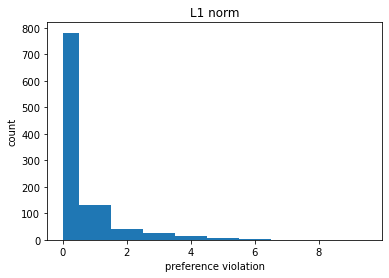

In [144]:
plt.hist(v_linear, bins = [0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]);
plt.title("L1 norm");
plt.xlabel("preference violation");
plt.ylabel("count");

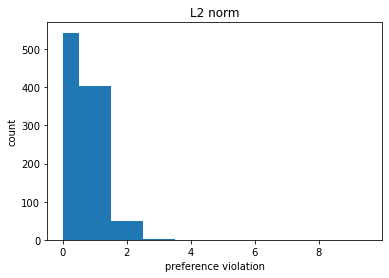

In [145]:
plt.hist(v_quadratic, bins = [0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]);
plt.title("L2 norm");
plt.xlabel("preference violation");
plt.ylabel("count");

In [146]:
print(f"Number of non-zero preference violations with L1 norm equivalent: {(v_linear > 0.001).sum()}")
print(f"Number of non-zero preference violations with L2 norm equivalent: {(v_quadratic > 0.001).sum()}")

Number of non-zero preference violations with L1 norm equivalent: 235
Number of non-zero preference violations with L2 norm equivalent: 781


L2 norm minimization tends to avoid large outliers but does not put emphasize on values close to zero.

L1 norm minimization includes rather large outliers but most values are basically zero.